# Active Learning Part (Working Notebook)

This notebook contains the active learning part of the project. The main goal of this part is to implement the active learning algorithms (Query-by-Committee and IDEAL) and compare them to their respective random sampling method. The dataset used in this part is the dpsDeriv1200 dataset containing second derivative spectral FTIR data from wooden samples.

Links and Code used in this code:
- https://github.com/modAL-python/modAL/blob/master/examples/query_by_committee.py
- https://github.com/modAL-python/modAL/blob/master/examples/pool-based_sampling.py
- https://github.com/modAL-python/modAL/blob/master/examples/active_regression.py
- A. Géron, Hands-on Machine Learning with Scikit-Learn, Keras & TensorFlow, Second Edi., vol. 44, no. 8. O’Reilly Media Inc., 2019.

## Loading of data

dpsDeriv1200 had to be adjusted manually by removing the X before the Wavelength nammes in the column headers

In [1]:
import pandas as pd
import numpy as np

# set random seed
np.random.seed(42)

# load data from csv file
data_deriv = pd.read_csv("dpsDeriv1200.csv")

# rename columns to remove leading 'X'
data_deriv.columns = [col.replace("X", "") for col in data_deriv.columns]

# show the first few rows of the data
print(data_deriv.head())

     Unnamed: 0  year     tree Origin    type          2970          2968  \
0  2GOS-18_1955  1955  2GOS-18    POL  living -7.236150e-08  4.010600e-07   
1  2GOS-18_1969  1969  2GOS-18    POL  living  1.739940e-05  4.649250e-06   
2  2GOS-18_1974  1974  2GOS-18    POL  living  1.629130e-05  1.129150e-05   
3  2GOS-18_1976  1976  2GOS-18    POL  living  9.659060e-06  4.122150e-06   
4  2GOS-18_1996  1996  2GOS-18    POL  living  9.218540e-06  3.989240e-06   

       2966          2964      2962  ...           818       816       814  \
0  0.000005  1.310370e-05  0.000018  ... -4.740000e-06 -0.000020 -0.000034   
1 -0.000007 -1.769050e-05 -0.000026  ... -2.730000e-07 -0.000016 -0.000031   
2  0.000006  5.111420e-07 -0.000005  ... -1.890000e-06 -0.000014 -0.000025   
3  0.000003  4.831610e-06  0.000003  ... -1.630000e-06 -0.000016 -0.000030   
4 -0.000006 -1.145560e-05 -0.000007  ...  2.350000e-07 -0.000010 -0.000023   

        812       810       808       806       804       802       

## Preparation of data

The data was split into a training and test set the same way as in the Notebook "Hyper-parameter Optimization, Model Validation and Permutation Importance I" as the same dataset is used.

In [4]:
from copy import deepcopy
data = deepcopy(data_deriv)

def categorize_years(year):
    """
    Categorizes a given year into one of four historical periods.

    Parameters:
    year (int): The year to be categorized.

    Returns:
    int: A numerical category representing the period the year falls into:
         - 1: 1150 to 1400
         - 2: 1401 to 1600
         - 3: 1601 to 1800
         - 4: 1801 to 2010

    Notes:
    - The minimum and maximum year boundaries have been adjusted to start from 1150 and end at 2010, respectively.
    """
    if 1150 <= year <= 1400: # adjustment because of min value
        return 1
    elif 1401 <= year <= 1600:
        return 2
    elif 1601 <= year <= 1800:
        return 3
    elif 1801 <= year <= 2010: # agjustment because of max value
        return 4 

# Should generate age categories which can be used from StratifiedShuffleSplit while splitting the data the train and the test set.  

data["category"] = data["year"].apply(categorize_years)

print(data)

         Unnamed: 0  year      tree Origin    type          2970  \
0      2GOS-18_1955  1955   2GOS-18    POL  living -7.236150e-08   
1      2GOS-18_1969  1969   2GOS-18    POL  living  1.739940e-05   
2      2GOS-18_1974  1974   2GOS-18    POL  living  1.629130e-05   
3      2GOS-18_1976  1976   2GOS-18    POL  living  9.659060e-06   
4      2GOS-18_1996  1996   2GOS-18    POL  living  9.218540e-06   
...             ...   ...       ...    ...     ...           ...   
1285  SZLPS15a_1942  1942  SZLPS15a    AUT  living  1.930000e-06   
1286  SZLPS15a_1952  1952  SZLPS15a    AUT  living  1.410000e-06   
1287  SZLPS15a_1962  1962  SZLPS15a    AUT  living -1.980000e-06   
1288  SZLPS15a_1972  1972  SZLPS15a    AUT  living  3.140000e-06   
1289  SZLPS15a_1982  1982  SZLPS15a    AUT  living -7.300000e-07   

              2968      2966          2964          2962  ...       816  \
0     4.010600e-07  0.000005  1.310370e-05  1.788600e-05  ... -0.000020   
1     4.649250e-06 -0.000007 -1.7

### Separation of dataset into train and test set (using StratifiedShuffleSplit)

StratifiedShuffleSplit is a variation of ShuffleSplit, which returns stratified splits, i.e which creates splits by preserving the same percentage for each target class as in the complete set

The following code (splitting the data with StratifiedShuffleSplit and calculating the percentages of the categories) is based on the code from the book "Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow" by Aurélien Géron.

Reference:
A. Géron, Hands-on Machine Learning with Scikit-Learn, Keras & TensorFlow, Second Edi., vol. 44, no. 8. O’Reilly Media Inc., 2019.

In [5]:
# credits to book "Hands-on-Maschine-Learning"!
from sklearn.model_selection import StratifiedShuffleSplit

# split data
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2)
for train_index, test_index in sss.split(data, data["category"]):
    data_train_set = data.loc[train_index]
    data_test_set = data.loc[test_index]

In [6]:
data_test_set["category"].value_counts() / len(data_test_set)

category
4    0.445736
3    0.325581
2    0.162791
1    0.065891
Name: count, dtype: float64

In [7]:
data_train_set["category"].value_counts() / len(data_train_set)

category
4    0.444767
3    0.324612
2    0.162791
1    0.067829
Name: count, dtype: float64

In [8]:
# "category" should be removed from the data to reach the original state again

for set_ in (data_train_set, data_test_set):
    set_.drop("category", axis=1, inplace=True)

print(data_train_set)

         Unnamed: 0  year      tree Origin    type      2970          2968  \
240   AMEPS07a_1652  1652  AMEPS07a    AUT  constr  0.000006 -7.140400e-06   
829      JMS8b_1744  1744     JMS8b    FIN  living  0.000018  8.310000e-06   
1095  SMGPS26b_1799  1799  SMGPS26b    AUT  constr  0.000002  3.440000e-08   
162       2TW5_1420  1420      2TW5    POL  constr  0.000007  1.149930e-05   
871      KOM2a_1973  1973     KOM2a    FIN  living  0.000015  8.650000e-06   
...             ...   ...       ...    ...     ...       ...           ...   
673   ENTPS06a_1923  1923  ENTPS06a    AUT  living  0.000020  8.040000e-06   
452      Dev1b_1919  1919     Dev1b    NOR  living  0.000036  2.220000e-05   
730   ENTPS13a_1940  1940  ENTPS13a    AUT  living  0.000019  1.650000e-05   
822      JMS7a_1811  1811     JMS7a    FIN  living  0.000007  2.770000e-06   
806      JMS4b_1967  1967     JMS4b    FIN  living  0.000009  2.280000e-06   

              2966          2964      2962  ...           818  

In [9]:
len(data_train_set)

1032

In [10]:
len(data_test_set)

258

### Removal of target variable

X and y (target variable) dataframes are separated. X has then only the important wavelengths left. 

#### Training Set

In [11]:
X_TRAIN = data_train_set.drop(
    ["year", "Unnamed: 0", "tree", "Origin", "type"], axis=1
)  # remove target variable, remove everything else which is not FTIR related?
X_TRAIN

2970          2968          2966          2964      2962  \
240   0.000006 -7.140400e-06 -1.559380e-05 -1.942950e-05 -0.000018   
829   0.000018  8.310000e-06  2.370000e-06 -3.150000e-06 -0.000009   
1095  0.000002  3.440000e-08  6.520000e-07  3.570000e-06  0.000008   
162   0.000007  1.149930e-05  1.191940e-05  1.244570e-05  0.000013   
871   0.000015  8.650000e-06 -1.090000e-06 -1.200000e-05 -0.000017   
...        ...           ...           ...           ...       ...   
673   0.000020  8.040000e-06 -9.680000e-06 -2.740000e-05 -0.000041   
452   0.000036  2.220000e-05  7.520000e-06 -6.320000e-06 -0.000018   
730   0.000019  1.650000e-05  1.370000e-05  1.030000e-05  0.000005   
822   0.000007  2.770000e-06  1.560000e-06 -6.610000e-07 -0.000002   
806   0.000009  2.280000e-06 -2.770000e-06 -7.650000e-06 -0.000012   

              2960          2959      2957      2955      2953  ...  \
240  -8.880820e-06  7.451600e-06  0.000026  0.000040  0.000040  ...   
829  -1.070000e-05 -6.370000e-06  0.000001  0.000010  0.000016  ...   
1095  1.150000e-05  1.460000e-05  0.000019  0.000024  0.000027  ...   
162   9.896220e-06  5.810760e-06  0.000003  0.000004  0.000009  ...   
871  -1.050000e-05  9.970000e-07  0.000011  0.000016  0.000018  ...   
...            ...           ...       ...       ...       ...  ...   
673  -4.760000e-05 -4.490000e-05 -0.000033 -0.000012  0.000011  ...   
452  -2.690000e-05 -3.070000e-05 -0.000028 -0.000016  0.000005  ...   
730   7.500000e-08 -2.460000e-07  0.000003  0.000009  0.000015  ...   
822   1.880000e-06  9.850000e-06  0.000016  0.000018  0.000020  ...   
806  -9.840000e-06 -1.430000e-07  0.000012  0.000021  0.000024  ...   

               818           816       814       812       810       808  \
240  -2.650000e-05 -5.030000e-05 -0.000067 -0.000075 -0.000074 -0.000067   
829  -2.440000e-06 -2.240000e-05 -0.000040 -0.000052 -0.000058 -0.000057   
1095 -1.180000e-05 -3.080000e-05 -0.000048 -0.000060 -0.000064 -0.000061   
162  -2.200000e-05 -4.440000e-05 -0.000064 -0.000078 -0.000080 -0.000070   
871   6.030000e-06 -1.300000e-05 -0.000030 -0.000043 -0.000052 -0.000056   
...            ...           ...       ...       ...       ...       ...   
673   2.920000e-06 -1.930000e-05 -0.000038 -0.000050 -0.000057 -0.000058   
452   1.250000e-05  7.770000e-07 -0.000013 -0.000027 -0.000038 -0.000044   
730  -3.120000e-08 -1.650000e-05 -0.000033 -0.000047 -0.000055 -0.000055   
822  -1.410000e-06 -1.490000e-05 -0.000028 -0.000038 -0.000043 -0.000042   
806   5.780000e-06 -1.540000e-05 -0.000036 -0.000051 -0.000058 -0.000060   

           806       804       802       800  
240  -0.000053 -0.000035 -0.000017 -0.000002  
829  -0.000049 -0.000034 -0.000015  0.000003  
1095 -0.000050 -0.000036 -0.000020 -0.000006  
162  -0.000053 -0.000036 -0.000021 -0.000007  
871  -0.000054 -0.000045 -0.000031 -0.000016  
...        ...       ...       ...       ...  
673  -0.000053 -0.000042 -0.000029 -0.000016  
452  -0.000042 -0.000034 -0.000023 -0.000012  
730  -0.000050 -0.000041 -0.000030 -0.000017  
822  -0.000037 -0.000028 -0.000018 -0.000007  
806  -0.000056 -0.000046 -0.000033 -0.000019  

[1032 rows x 410 columns]

In [12]:
y_TRAIN = data_train_set["year"]  # target variable
y_TRAIN

240     1652
829     1744
1095    1799
162     1420
871     1973
        ... 
673     1923
452     1919
730     1940
822     1811
806     1967
Name: year, Length: 1032, dtype: int64

#### Test Set

In [13]:
X_TEST = data_test_set.drop(
    ["year", "Unnamed: 0", "tree", "Origin", "type"], axis=1
)  # remove target variable, remove everything else which is not FTIR related?
X_TEST

2970          2968      2966      2964          2962      2960  \
1094  0.000003  7.190000e-06  0.000012  0.000016  1.820000e-05  0.000018   
1238  0.000014  1.280000e-05  0.000010  0.000010  1.090000e-05  0.000015   
84    0.000007  6.668880e-06  0.000008  0.000008  5.827080e-06  0.000006   
245   0.000010  1.359460e-06 -0.000009 -0.000019 -2.098340e-05 -0.000013   
39    0.000018  1.442250e-05  0.000006 -0.000003 -1.005330e-05 -0.000013   
...        ...           ...       ...       ...           ...       ...   
858   0.000011  1.190000e-05  0.000004 -0.000007 -9.740000e-06  0.000002   
1225  0.000024  1.700000e-05  0.000006 -0.000004 -1.020000e-05 -0.000013   
76    0.000013 -7.951200e-07 -0.000011 -0.000015 -1.515580e-05 -0.000011   
40    0.000019  1.226400e-05  0.000002 -0.000004 -5.149220e-06 -0.000006   
1217  0.000019  1.210000e-05  0.000003 -0.000001  9.810000e-07  0.000005   

              2959          2957      2955      2953  ...       818       816  \
1094  1.630000e-05  1.540000e-05  0.000016  0.000014  ... -0.000011 -0.000030   
1238  2.050000e-05  2.360000e-05  0.000024  0.000025  ... -0.000011 -0.000034   
84    1.085430e-05  1.629050e-05  0.000022  0.000028  ... -0.000009 -0.000031   
245   6.417020e-07  1.657700e-05  0.000029  0.000034  ... -0.000016 -0.000035   
39   -7.761540e-06  2.301340e-06  0.000012  0.000020  ... -0.000015 -0.000029   
...            ...           ...       ...       ...  ...       ...       ...   
858   1.710000e-05  2.660000e-05  0.000029  0.000030  ... -0.000002 -0.000024   
1225 -9.710000e-06 -1.820000e-06  0.000007  0.000016  ... -0.000006 -0.000027   
76   -1.020930e-06  1.666490e-05  0.000037  0.000049  ... -0.000009 -0.000034   
40   -5.902270e-06  6.493740e-07  0.000012  0.000024  ... -0.000011 -0.000036   
1217  1.190000e-05  1.960000e-05  0.000025  0.000026  ... -0.000006 -0.000026   

           814       812       810       808       806       804       802  \
1094 -0.000047 -0.000057 -0.000059 -0.000054 -0.000044 -0.000030 -0.000015   
1238 -0.000055 -0.000071 -0.000076 -0.000071 -0.000058 -0.000042 -0.000025   
84   -0.000049 -0.000060 -0.000065 -0.000064 -0.000057 -0.000046 -0.000031   
245  -0.000050 -0.000062 -0.000069 -0.000068 -0.000059 -0.000044 -0.000026   
39   -0.000039 -0.000044 -0.000042 -0.000036 -0.000026 -0.000016 -0.000006   
...        ...       ...       ...       ...       ...       ...       ...   
858  -0.000044 -0.000058 -0.000065 -0.000063 -0.000055 -0.000041 -0.000027   
1225 -0.000044 -0.000057 -0.000062 -0.000061 -0.000054 -0.000043 -0.000029   
76   -0.000056 -0.000069 -0.000074 -0.000070 -0.000059 -0.000044 -0.000026   
40   -0.000059 -0.000073 -0.000076 -0.000070 -0.000057 -0.000039 -0.000021   
1217 -0.000044 -0.000057 -0.000062 -0.000060 -0.000052 -0.000040 -0.000026   

           800  
1094 -0.000003  
1238 -0.000008  
84   -0.000015  
245  -0.000008  
39    0.000002  
...        ...  
858  -0.000014  
1225 -0.000014  
76   -0.000008  
40   -0.000007  
1217 -0.000013  

[258 rows x 410 columns]

In [14]:
y_TEST = data_test_set["year"]  # target variable
y_TEST

1094    1789
1238    1920
84      1664
245     1702
39      1770
        ... 
858     1387
1225    1957
76      1593
40      1780
1217    1877
Name: year, Length: 258, dtype: int64

## Active Learning Part I (Query-by-Committee)

- Pandas does not support append operation since Pandas 2.0 >> https://github.com/pydata/pandas-datareader/issues/966. Therefore the pandas dataframes of X and y need to be changed from pandas dataframes to numpy arrays using df.to_numpy()
- This active learning approach uses **max_std_sampling** as the number of samples to be selected for the next iteration. The samples are selected based on the highest standard deviation of the predictions of the model.
- The hyper-parameter optimized regression models are used in this active learning approach.

### Random Forest Regression Model (without scaling)

#### Iterating through all committee members and all initial sample sizes 

The goal is to find the best combination of committee members and initial sample sizes. To accomplish that the following code will iterate through all committee members and all initial sample sizes. The other hyperparameters will be kept constant.

 Current size of the committee: 2
 Initial samples of each committee member: 5
 Initial samples of each committee member: 10
 Initial samples of each committee member: 15
 Initial samples of each committee member: 20
 Initial samples of each committee member: 25
 Initial samples of each committee member: 30
 Initial samples of each committee member: 35
 Initial samples of each committee member: 40
 Initial samples of each committee member: 45
 Initial samples of each committee member: 50
 Current size of the committee: 4
 Initial samples of each committee member: 5
 Initial samples of each committee member: 10
 Initial samples of each committee member: 15
 Initial samples of each committee member: 20
 Initial samples of each committee member: 25
 Initial samples of each committee member: 30
 Initial samples of each committee member: 35
 Initial samples of each committee member: 40
 Initial samples of each committee member: 45
 Initial samples of each committee member: 50
 Current size 

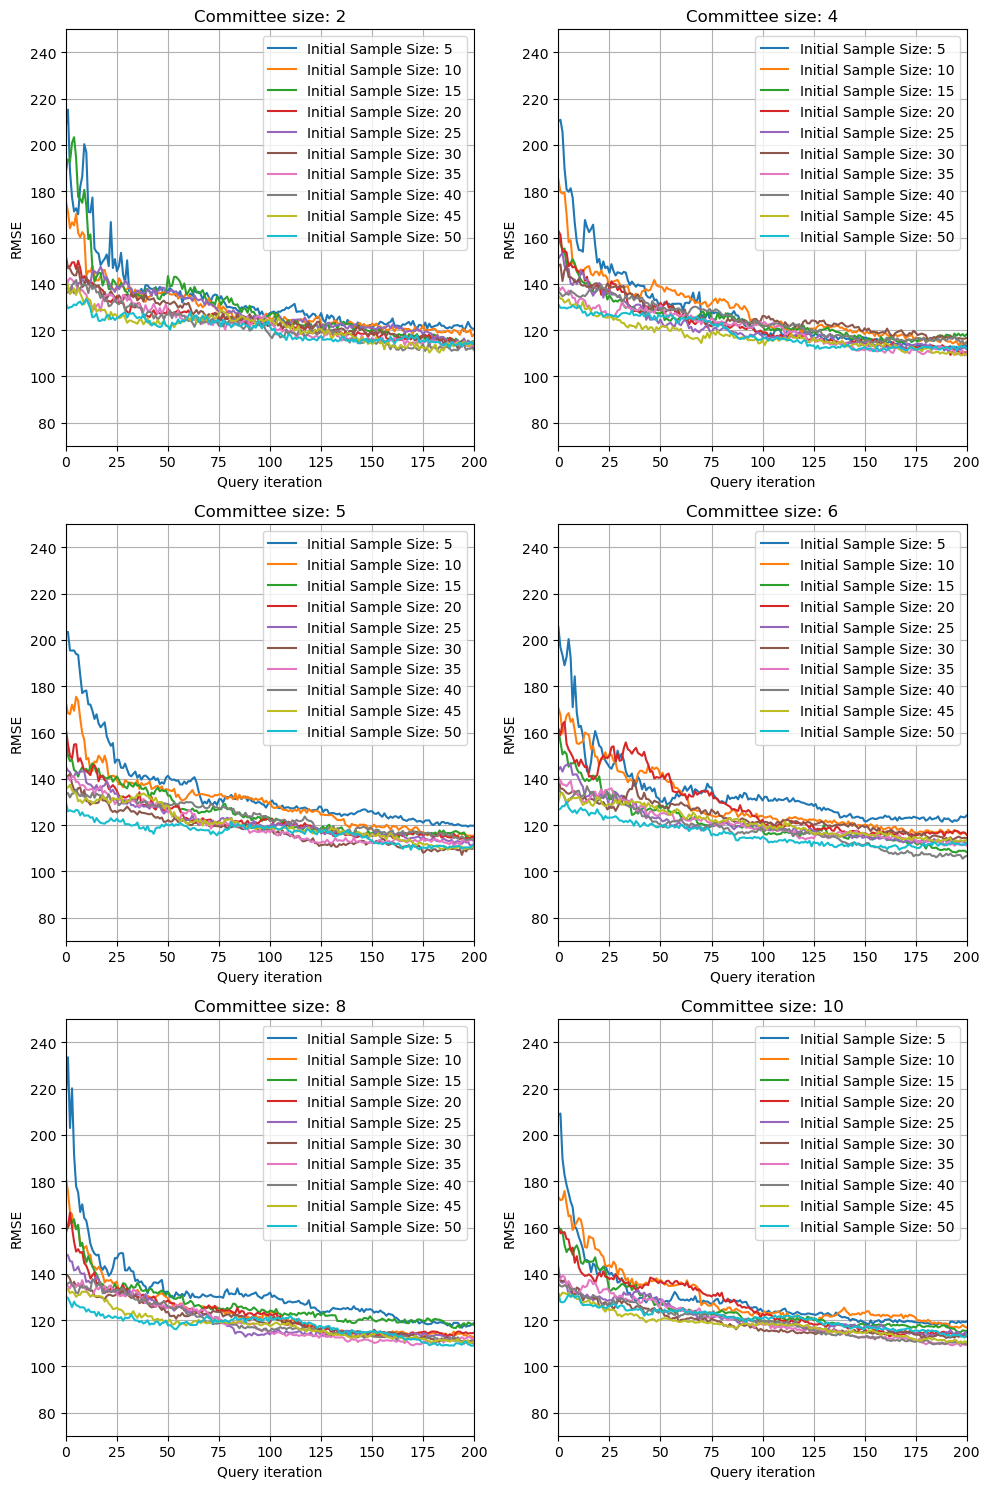

In [16]:
# when using deepcopy a fully independent copy of the object is created (otherwhise the oriiginal data could be altered)
from copy import deepcopy
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import root_mean_squared_error
from modAL.models import ActiveLearner, CommitteeRegressor
from modAL.disagreement import max_std_sampling

# storing of initial training data (which is not altered!)
X_pool_original = deepcopy(X_TRAIN).to_numpy()
y_pool_original = deepcopy(y_TRAIN).to_numpy()

# test data
X_test = deepcopy(X_TEST).to_numpy()
y_test = deepcopy(y_TEST).to_numpy()

# defining the committee size which will be tested
committee_size = [2, 4, 5, 6, 8, 10]

# defining the initial sample size which will be tested
n_initial_size = [
    5,
    10,
    15,
    20,
    25,
    30,
    35,
    40,
    45,
    50,
]  # random samples from the pool (randomly selected)

# Results are stored in a nested dictionary
rsme_results = {size: {} for size in committee_size}


for n_members in committee_size:
    print(f" Current size of the committee: {n_members}")

    for n_initial in n_initial_size:
        print(f" Initial samples of each committee member: {n_initial}")

        # store all the members of the initialized committee
        learner_list = []

        # create a deep copy of the pool to ensure that the original data is not altered
        # and to ensure that all initial sizes and committee sizes are tested with the whole pool!
        X_pool = deepcopy(X_pool_original)
        y_pool = deepcopy(y_pool_original)

        # list of indices where random samples are choosen for initialization
        remaining_idx = list(range(len(X_pool)))  # generates list of indices

        for member_idx in range(
            n_members
        ):  # each iteration of the loop trains a new member of the committee

            # Stop if not enough samples remain for the required number of initial samples
            if len(remaining_idx) < n_initial:
                break

            # select random indices for training data from remaining indices
            train_idx = np.random.choice(
                remaining_idx, size=n_initial, replace=False
            )  # random indices

            # initial traning data
            X_train = X_pool[train_idx]
            y_train = y_pool[train_idx]

            # initializing the learner
            learner = ActiveLearner(
                estimator=RandomForestRegressor(
                    n_estimators=120, min_samples_split=5, min_samples_leaf=1, n_jobs=60
                ),
                X_training=X_train,
                y_training=y_train,
            )

            # Apend learner to the list of learners
            learner_list.append(learner)  # holds all members of the committee

            # Update the remaining idexes
            remaining_idx = [idx for idx in remaining_idx if idx not in train_idx]

        # Update the pool
        X_pool_remaining = X_pool[remaining_idx]
        y_pool_remaining = y_pool[remaining_idx]

        # creates the committee instance with all individual learners forming a committee
        committee = CommitteeRegressor(
            learner_list=learner_list, query_strategy=max_std_sampling
        )  

        # plot the initial prediction from the committee
        unqueried_y_pred = committee.predict(X_test)
        unqueried_rsme = root_mean_squared_error(y_test, unqueried_y_pred)
        # print("Root Mean Squared Error (RMSE) before active learning:", unqueried_rsme)

        # Active Learning - Query by Committee
        # number of queries:
        n_queries = 200
        rsme_values = [
            unqueried_rsme
        ]  # start with unqueries RSME before the active learning
        # Active learning loop
        for idx in range(n_queries):
            # query the committee for a new instance
            query_idx, query_instance = committee.query(X_pool_remaining)
            # teach the committee the new instance
            committee.teach(
                X_pool_remaining[query_idx], y_pool_remaining[query_idx]
            )  
            # predict the RSME based on the test set
            y_pred = committee.predict(X_test)
            rsme = root_mean_squared_error(y_test, y_pred)
            # print(f"Root Mean Squared Error (RMSE) after query {idx+1}: {rsme}")
            # append RSME value of the query to the list
            rsme_values.append(rsme)
            # delecte query from the pool
            X_pool_remaining = np.delete(
                X_pool_remaining, query_idx, axis=0
            )  # delete the queried instance from the pool
            y_pool_remaining = np.delete(
                y_pool_remaining, query_idx
            )  # delete the queried instance from the pool

        # Store RSME values for each respective committee size
        rsme_results[n_members][n_initial] = rsme_values

# PLOT SECTION
# results are visualized with one plot per committee size which includes all the n_initial sizes
# generate a figure with 2 rows and 3 columns

fig, axs = plt.subplots(3, 2, figsize=(10, 15))

# flatten the 2 D array of axes
axs = axs.ravel()

# iterates over committee sizes and their index
for idx, n_members in enumerate(committee_size):
    # selects the respective axis
    ax = axs[idx]
    # Iterates over the initial sample sizes and their RSME values for the current committee size
    for n_initial, rsme_values in rsme_results[n_members].items():
        ax.plot(
            range(len(rsme_values)),
            rsme_values,
            label=f"Initial Sample Size: {n_initial}",
        )

    # set title of subplot
    ax.set_title(f"Committee size: {n_members}")
    # label x-axis of subplot
    ax.set_xlabel("Query iteration")
    # label y-axis of subplot
    ax.set_ylabel("RMSE")
    # set limits of y-axis
    ax.set_ylim(70, 250)
    # set limits of x-axis
    ax.set_xlim(0, 200)
    # add grid to subplot
    ax.grid(True)
    # add legend to subplot
    ax.legend()

# tight layout
plt.tight_layout()

# save plot
plt.savefig("RF_Committee_200_long.png", bbox_inches="tight")
# show plot
plt.show()

#### Testing best model multiple times with varying random states

The best model will be tested multiple times with varying random seeds to assess the influence of the random seed on the model. The results will be saved and exported as a csv file.

Current iteration: 0
Current iteration: 1
Current iteration: 2
Current iteration: 3
Current iteration: 4
Current iteration: 5
Current iteration: 6
Current iteration: 7
Current iteration: 8
Current iteration: 9
Current iteration: 10
Current iteration: 11
Current iteration: 12
Current iteration: 13
Current iteration: 14
Current iteration: 15
Current iteration: 16
Current iteration: 17
Current iteration: 18
Current iteration: 19


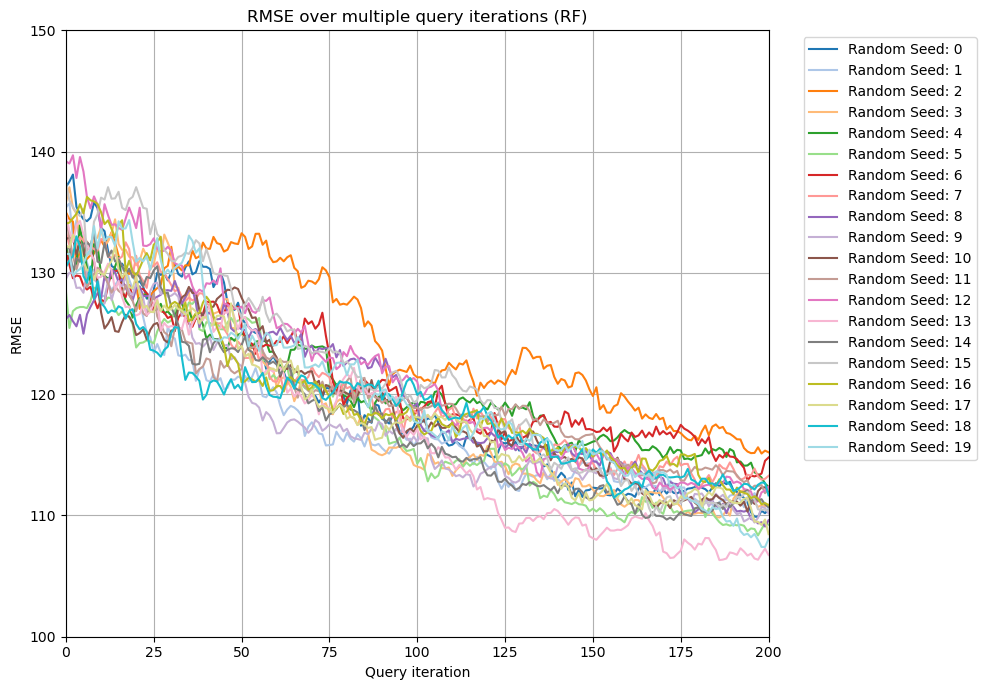

In [18]:
from copy import deepcopy
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import root_mean_squared_error
from modAL.models import ActiveLearner, CommitteeRegressor
from modAL.disagreement import max_std_sampling

# initial training data
X_pool_original = deepcopy(X_TRAIN).to_numpy()
y_pool_original = deepcopy(y_TRAIN).to_numpy()

# test data
X_test = deepcopy(X_TEST).to_numpy()
y_test = deepcopy(y_TEST).to_numpy()

# initializing of committee
n_members = 5
n_initial = 45  # random samples from the pool (randomly selected)

# Results are stored in a dictionary
rsme_results = {}
# number of iterations
iterations = 20

for i in range(iterations):
    print(f"Current iteration: {i}")

    # set random seed
    np.random.seed(i)

    # store all the members of the initialized committee
    learner_list = []

    # create a deep copy of the pool to ensure that the original data is not altered
    # and to ensure that all initial sizes and committee sizes are tested with the whole pool!
    X_pool = deepcopy(X_pool_original)
    y_pool = deepcopy(y_pool_original)

    # list of indices where random samples are choosen for initialization
    remaining_idx = list(range(len(X_pool)))  # generates list of indices

    for member_idx in range(
        n_members
    ):  # each iteration of the loop trains a new member of the committee

        # Stop if not enough samples remain for the required number of initial samples
        if len(remaining_idx) < n_initial:
            break

        # select random indices for training data from remaining indices
        train_idx = np.random.choice(
            remaining_idx, size=n_initial, replace=False
        )  

        # initial traning data
        X_train = X_pool[train_idx]
        y_train = y_pool[train_idx]

        # initializing the learner
        learner = ActiveLearner(
            estimator=RandomForestRegressor(
                n_estimators=120,
                min_samples_split=5,
                min_samples_leaf=1,
                n_jobs=50,
                random_state=i,
            ),
            X_training=X_train,
            y_training=y_train,
        )

        # Append learner to the list of learners
        learner_list.append(learner)  # holds all members of the committee

        # Update the remaining idexes
        remaining_idx = [idx for idx in remaining_idx if idx not in train_idx]

    # Update the pool
    X_pool_remaining = X_pool[remaining_idx]
    y_pool_remaining = y_pool[remaining_idx]

    # creates the committee instance with all individual learners forming a committee
    committee = CommitteeRegressor(
        learner_list=learner_list, query_strategy=max_std_sampling
    )  

    # plot the initial prediction from the committee
    unqueried_y_pred = committee.predict(X_test)
    unqueried_rsme = root_mean_squared_error(y_test, unqueried_y_pred)
    # print("Root Mean Squared Error (RMSE) before active learning:", unqueried_rsme)

    # Active Learning - Query by Committee
    # number of queries:
    n_queries = 200
    rsme_values = [
        unqueried_rsme
    ]  # start with unqueries RSME before active learning
    # Active learning loop
    for idx in range(n_queries):
        # query the committee for a new instance
        query_idx, query_instance = committee.query(X_pool_remaining)
        # teach the query to the committee
        committee.teach(
            X_pool_remaining[query_idx], y_pool_remaining[query_idx]
        )  # teach the committee the new instance
        # predict the RSME based on the test set
        y_pred = committee.predict(X_test)
        rsme = root_mean_squared_error(y_test, y_pred)
        # print(f"Root Mean Squared Error (RMSE) after query {idx+1}: {rsme}")
        # append RSME value of the query to the list
        rsme_values.append(rsme)
        # delete query from the pool
        X_pool_remaining = np.delete(
            X_pool_remaining, query_idx, axis=0
        )  
        y_pool_remaining = np.delete(
            y_pool_remaining, query_idx
        )  

    # Store RSME values for each random seed
    rsme_results[i] = rsme_values

# save the results as a csv file
rsme_df = pd.DataFrame(rsme_results)
rsme_df.to_csv("RF_RSME_results_2.csv")

# Plot section
plt.figure(figsize=(10, 7))
cmap = plt.get_cmap("tab20")

for i, rsme_values in rsme_results.items():
    color = cmap(i / iterations)  # color map
    plt.plot(
        range(len(rsme_values)), rsme_values, label=f"Random Seed: {i}", color=color
    )

# set title of plot
plt.title("RMSE over multiple query iterations (RF/QBC)")
# set limits of x-axis
plt.xlabel("Query iteration")
# set limits of y-axis
plt.ylabel("RMSE")
# set limits of y-axis
plt.ylim(100, 150)
# set limits of x-axis
plt.xlim(0, 200)
# add grid
plt.grid(True)
# add legend
plt.legend(loc="upper left", bbox_to_anchor=(1.04, 1))
# tight layout
plt.tight_layout()
# save plot
plt.savefig("RF_multiple_iterations_2.png")
# show plot
plt.show()

#### Comparison to representative supervised ML 

The best model will be compared to a representative supervised ML model to see if the active learning model is better than the supervised ML model. The supervised ML model will be trained on the same amount of training data as the respective active learning model. These samples will be selected randomly from the training set (245 samples). This will be done with the same random seeds and the mean, median, and standard deviation of the results will be calculated.

In [22]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error
from copy import deepcopy
import numpy as np

# number of iterations
iterations = 20

# number of random samples
n_samples = 245

# store RSME results
rsme_results_rf = []

for i in range(iterations):

    # set random seed
    np.random.seed(i)

    # test data stays the same!
    X_test = deepcopy(X_TEST)
    y_test = deepcopy(y_TEST)

    # Generate the comparable train set with 245 samples (randomly selected)
    X_train_unscaled = deepcopy(X_TRAIN)
    y_train_unscaled = deepcopy(y_TRAIN)

    # available list of indices
    sample_idx = list(range(len(X_train_unscaled)))  # generates list of indices

    # Select random indices for training data selection from remaining indices
    train_samples = np.random.choice(sample_idx, size=n_samples, replace=False)

    # initial traning data
    X_train_adj = X_train_unscaled.iloc[train_samples]
    y_train_adj = y_train_unscaled.iloc[train_samples]

    # initializing the learner
    rf_reg = RandomForestRegressor(
        n_estimators=120,
        min_samples_split=5,
        min_samples_leaf=1,
        n_jobs=30,
        random_state=i,
    )

    # Fit the model
    rf_reg_fit = rf_reg.fit(X_train_adj, y_train_adj)

    # Predict the y values
    y_pred_rf = rf_reg_fit.predict(X_test)

    # Calculate RSME
    RSME_rf = root_mean_squared_error(y_test, y_pred_rf)

    # Print RSME
    #print(f"RSME: {RSME_rf} for random seed: {i}")

    # append RSME to the list
    rsme_results_rf.append(RSME_rf)

# Calculate mean, median and standard deviation of the RSME values
mean_rsme_rf = np.mean(rsme_results_rf)
median_rsme_rf = np.median(rsme_results_rf)
std_rsme_rf = np.std(rsme_results_rf)

# print results
print(f"Model Fitting: RMSE Mean: {mean_rsme_rf} and Standard Deviation: {std_rsme_rf}")
print(f"Model Fitting: RMSE Median: {median_rsme_rf} and Standard Deviation: {std_rsme_rf}")


Model Fitting: RMSE Mean: 117.7255950964759 and Standard Deviation: 3.8948175148594815
Model Fitting: RMSE Median: 118.89136778822191 and Standard Deviation: 3.8948175148594815


### Support Vector Regression (SVR) - with scaling

The next regression model that is tested is the Support Vector Regression (SVR). The data is scaled using the StandardScaler from sklearn. The same active learning approach is used as for the Random Forest Regression Model.

#### Iterating through all committee members and all initial sample sizes

The goal is to find the best combination of committee members and initial sample sizes. To accomplish that the following code will iterate through all committee members and all initial sample sizes. The other hyperparameters will be kept constant.

 Current size of the committee: 2
 Initial samples of each committee member: 5
 Initial samples of each committee member: 10
 Initial samples of each committee member: 15
 Initial samples of each committee member: 20
 Initial samples of each committee member: 25
 Initial samples of each committee member: 30
 Initial samples of each committee member: 35
 Initial samples of each committee member: 40
 Initial samples of each committee member: 45
 Initial samples of each committee member: 50
 Current size of the committee: 4
 Initial samples of each committee member: 5
 Initial samples of each committee member: 10
 Initial samples of each committee member: 15
 Initial samples of each committee member: 20
 Initial samples of each committee member: 25
 Initial samples of each committee member: 30
 Initial samples of each committee member: 35
 Initial samples of each committee member: 40
 Initial samples of each committee member: 45
 Initial samples of each committee member: 50
 Current size 

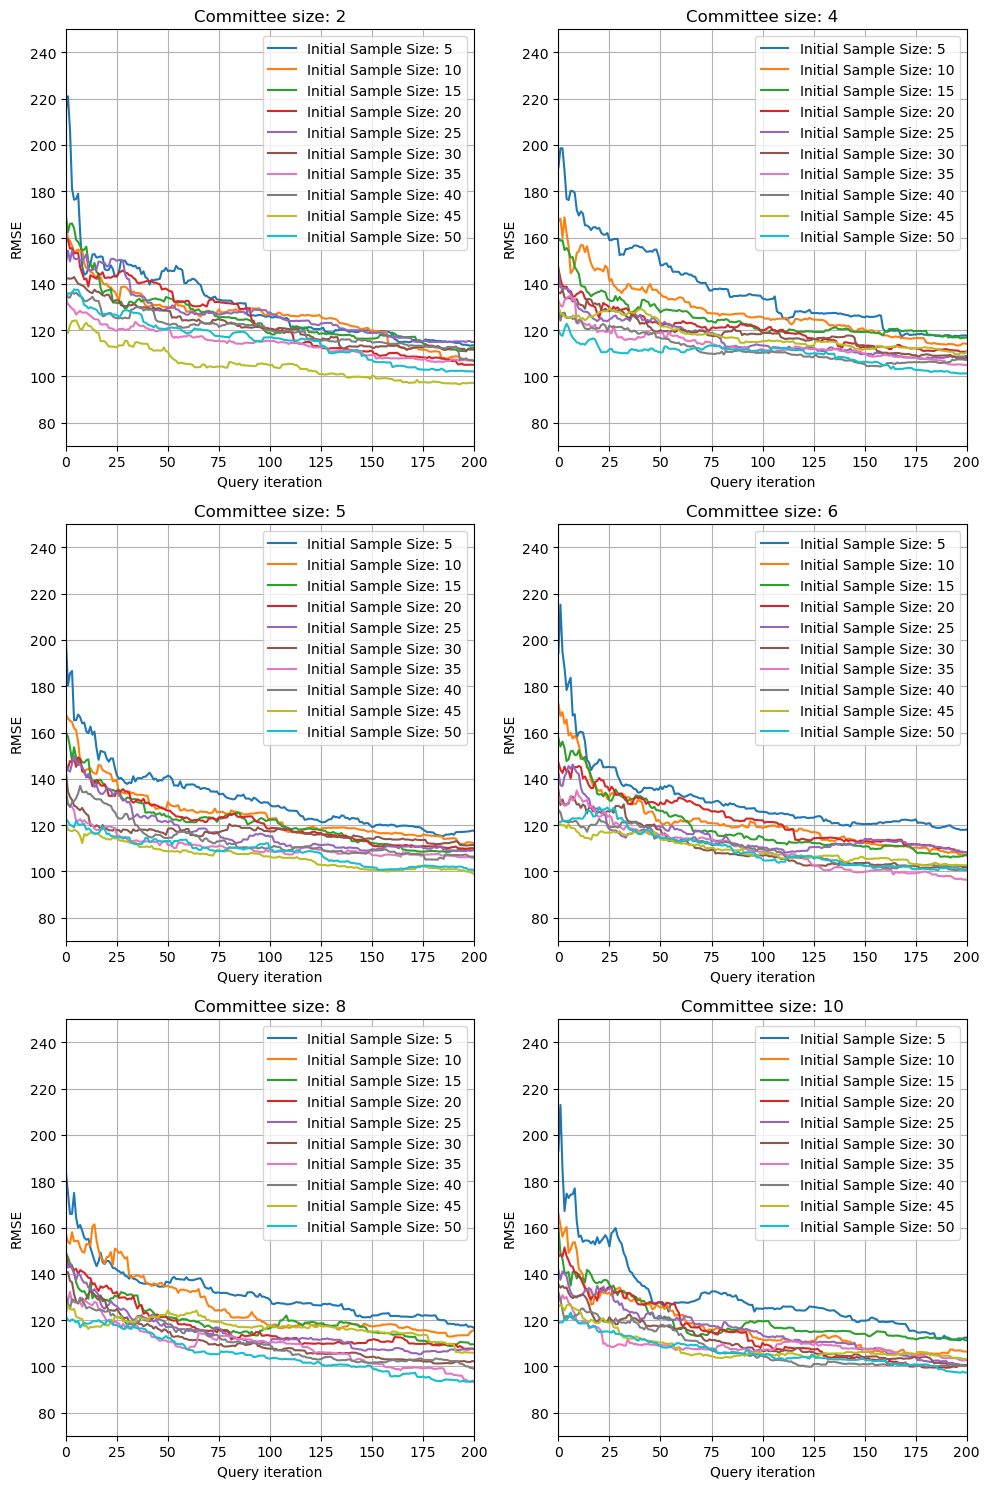

In [15]:
from copy import deepcopy
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import root_mean_squared_error
from modAL.models import ActiveLearner, CommitteeRegressor
from modAL.disagreement import max_std_sampling

# initial training data
X_pool_unscaled = deepcopy(X_TRAIN).to_numpy()
y_pool_original = deepcopy(y_TRAIN).to_numpy()

# test data
X_test_unscaled = deepcopy(X_TEST).to_numpy()
y_test = deepcopy(y_TEST).to_numpy()

# SCALING OF DATA!
# instantiate StandardScaler
scaler = StandardScaler()

# fit the scaler to the training data
scaler.fit(X_pool_unscaled)

# transform the training data
X_pool_original = scaler.transform(X_pool_unscaled)

# transform the test data
X_test = scaler.transform(X_test_unscaled)

# defining the committee sizes which will be tested
committee_size = [2, 4, 5, 6, 8, 10]

# defining the initial sample sizes which will be tested
n_initial_size = [
    5,
    10,
    15,
    20,
    25,
    30,
    35,
    40,
    45,
    50,
]  # random samples from the pool (randomly selected)

# Results are stored in a nested dictionary
rsme_results = {size: {} for size in committee_size}

for n_members in committee_size:
    print(f" Current size of the committee: {n_members}")

    for n_initial in n_initial_size:
        print(f" Initial samples of each committee member: {n_initial}")

        # store all the members of the initialized committee
        learner_list = []

        # create a deep copy of the pool to ensure that the original data is not altered
        # and to ensure that all initial sizes and committee sizes are tested with the whole pool!
        X_pool = deepcopy(X_pool_original)
        y_pool = deepcopy(y_pool_original)

        # list of indices where random samples are choosen for initialization
        remaining_idx = list(range(len(X_pool)))  # generates list of indices

        for member_idx in range(
            n_members
        ):  # each iteration of the loop trains a new member of the committee

            # Stop if not enough samples remain for the required number of initial samples
            if len(remaining_idx) < n_initial:
                break

            # select random indices for training data from remaining indices
            train_idx = np.random.choice(
                remaining_idx, size=n_initial, replace=False
            )  # random indices

            # initial traning data
            X_train = X_pool[train_idx]
            y_train = y_pool[train_idx]

            # initializing the learner
            learner = ActiveLearner(
                estimator=SVR(kernel="rbf", gamma="scale", C=3500.0, epsilon=0.01),
                X_training=X_train,
                y_training=y_train,
            )

            # Apend learner to the list of learners
            learner_list.append(learner)  # holds all members of the committee

            # Update the remaining idices
            remaining_idx = [idx for idx in remaining_idx if idx not in train_idx]

        # Update the pool
        X_pool_remaining = X_pool[remaining_idx]
        y_pool_remaining = y_pool[remaining_idx]

        # creates the committee instance with all individual learners forming a committee
        committee = CommitteeRegressor(
            learner_list=learner_list, query_strategy=max_std_sampling
        )  

        # plot the initial prediction from the committee
        unqueried_y_pred = committee.predict(X_test)
        unqueried_rsme = root_mean_squared_error(y_test, unqueried_y_pred)
        # print("Root Mean Squared Error (RMSE) before active learning:", unqueried_rsme)

        # Active Learning - Query by Committee
        # number of queries:
        n_queries = 200
        rsme_values = [
            unqueried_rsme
        ]  # start with unqueried RSME before the active learning
        # Active learning loop
        for idx in range(n_queries):
            # query the committee for a new instance
            query_idx, query_instance = committee.query(X_pool_remaining)
            # teach the query to the committee
            committee.teach(
                X_pool_remaining[query_idx], y_pool_remaining[query_idx]
            )  # teach the committee the new instance
            # predict the RSME based on the test set
            y_pred = committee.predict(X_test)
            rsme = root_mean_squared_error(y_test, y_pred)
            # print(f"Root Mean Squared Error (RMSE) after query {idx+1}: {rsme}")
            # append RSME value of the query to the list
            rsme_values.append(rsme)
            # delecte query from the pool
            X_pool_remaining = np.delete(
                X_pool_remaining, query_idx, axis=0
            )  
            y_pool_remaining = np.delete(
                y_pool_remaining, query_idx
            )  

        # Store RSME values for each respective committee size
        rsme_results[n_members][n_initial] = rsme_values

# PLOT SECTION
# results are visualized with one plot per committee size which includes all the n_initial sizes
# generate a figure with 2 rows and 3 columns

fig, axs = plt.subplots(3, 2, figsize=(10, 15))

# flatten the 2 D array of axes
axs = axs.ravel()

# iterates over committee sizes and their index
for idx, n_members in enumerate(committee_size):
    # selects the respective axis
    ax = axs[idx]
    # Iterates over the initial sample sizes and their RSME values for the current committee size
    for n_initial, rsme_values in rsme_results[n_members].items():
        ax.plot(
            range(len(rsme_values)),
            rsme_values,
            label=f"Initial Sample Size: {n_initial}",
        )

    # set title of subplot
    ax.set_title(f"Committee size: {n_members}")
    # label x-axis of subplot
    ax.set_xlabel("Query iteration")
    # label y-axis of subplot
    ax.set_ylabel("RMSE")
    # set limits of y-axis
    ax.set_ylim(70, 250)
    # set limits of x-axis
    ax.set_xlim(0, 200)
    # add grid to subplot
    ax.grid(True)
    # add legend to subplot
    ax.legend()

# tight layout
plt.tight_layout()
# save plot
plt.savefig("SVR_Committee_200_long.png", bbox_inches="tight")
# show plot
plt.show()

#### Testing best model multiple times with varying random states 

The best model will be tested multiple times with varying random seeds to assess the influence of the random seed on the model. The results will be saved and exported as a csv file.

Current iteration: 0


Current iteration: 1
Current iteration: 2
Current iteration: 3
Current iteration: 4
Current iteration: 5
Current iteration: 6
Current iteration: 7
Current iteration: 8
Current iteration: 9
Current iteration: 10
Current iteration: 11
Current iteration: 12
Current iteration: 13
Current iteration: 14
Current iteration: 15
Current iteration: 16
Current iteration: 17
Current iteration: 18
Current iteration: 19


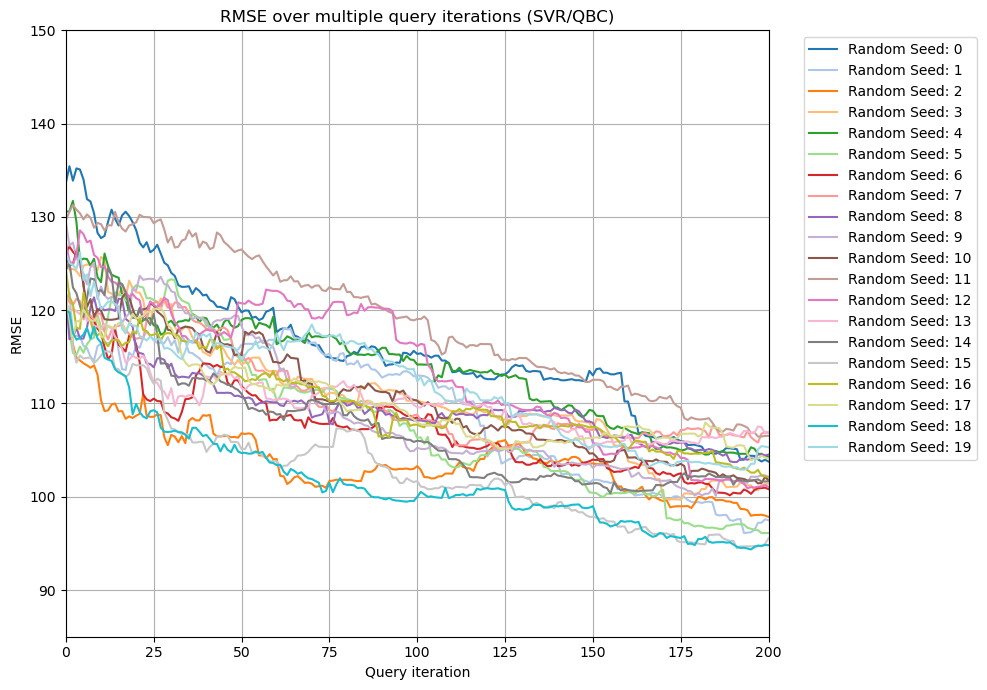

In [19]:
from copy import deepcopy
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import root_mean_squared_error
from modAL.models import ActiveLearner, CommitteeRegressor
from modAL.disagreement import max_std_sampling

# initial training data
X_pool_unscaled = deepcopy(X_TRAIN).to_numpy()
y_pool_original = deepcopy(y_TRAIN).to_numpy()

# test data
X_test_unscaled = deepcopy(X_TEST).to_numpy()
y_test = deepcopy(y_TEST).to_numpy()

# SCALING OF DATA!
# instantiate StandardScaler
scaler = StandardScaler()

# fit the scaler to the training data
scaler.fit(X_pool_unscaled)

# transform the training data
X_pool_original = scaler.transform(X_pool_unscaled)

# transform the test data
X_test = scaler.transform(X_test_unscaled)

# initializing of committee
n_members = 4
n_initial = 50  # random samples from the pool (randomly selected)

# Results are stored in a dictionary
rsme_results = {}
# number of iterations
iterations = 20

for i in range(iterations):
    print(f"Current iteration: {i}")

    # set random seed
    np.random.seed(i)

    # store all the members of the initialized committee
    learner_list = []

    # create a deep copy of the pool to ensure that the original data is not altered
    # and to ensure that all initial sizes and committee sizes are tested with the whole pool!
    X_pool = deepcopy(X_pool_original)
    y_pool = deepcopy(y_pool_original)

    # list of indices where random samples are choosen for initialization
    remaining_idx = list(range(len(X_pool)))  # generates list of indices

    for member_idx in range(
        n_members
    ):  # each iteration of the loop trains a new member of the committee

        # Stop if not enough samples remain for the required number of initial samples
        if len(remaining_idx) < n_initial:
            break

        # select random indices for training data from remaining indices
        train_idx = np.random.choice(
            remaining_idx, size=n_initial, replace=False
        ) 

        # initial traning data
        X_train = X_pool[train_idx]
        y_train = y_pool[train_idx]

        # initializing the learner
        learner = ActiveLearner(
            estimator=SVR(kernel="rbf", gamma="scale", C=3500.0, epsilon=0.01),
            X_training=X_train,
            y_training=y_train,
        )

        # Apend learner to the list of learners
        learner_list.append(learner)  # holds all members of the committee

        # Update the remaining idexes
        remaining_idx = [idx for idx in remaining_idx if idx not in train_idx]

    # Update the pool
    X_pool_remaining = X_pool[remaining_idx]
    y_pool_remaining = y_pool[remaining_idx]

    # creates the committee instance with all individual learners forming a committee
    committee = CommitteeRegressor(
        learner_list=learner_list, query_strategy=max_std_sampling
    )  

    # plot the initial prediction from the committee
    unqueried_y_pred = committee.predict(X_test)
    unqueried_rsme = root_mean_squared_error(y_test, unqueried_y_pred)
    # print("Root Mean Squared Error (RMSE) before active learning:", unqueried_rsme)

    # Active Learning - Query by Committee
    # number of queries:
    n_queries = 200
    rsme_values = [
        unqueried_rsme
    ]  # start with unqueries RSME before the active learning
    # Active learning loop
    for idx in range(n_queries):
        # query the committee for a new instance
        query_idx, query_instance = committee.query(X_pool_remaining)
        # teach the query to the committee
        committee.teach(
            X_pool_remaining[query_idx], y_pool_remaining[query_idx]
        )  # teach the committee the new instance
        # predict the RSME based on the test set
        y_pred = committee.predict(X_test)
        rsme = root_mean_squared_error(y_test, y_pred)
        # print(f"Root Mean Squared Error (RMSE) after query {idx+1}: {rsme}")
        # append RSME value of the query to the list
        rsme_values.append(rsme)
        # delecte query from the pool
        X_pool_remaining = np.delete(
            X_pool_remaining, query_idx, axis=0
        )  
        y_pool_remaining = np.delete(
            y_pool_remaining, query_idx
        )  

    # Store RSME values for each respective committee size
    rsme_results[i] = rsme_values

# save the results as a csv file
rsme_df = pd.DataFrame(rsme_results)
rsme_df.to_csv("SVR_RSME_results_2.csv")

# PLOT SECTION
plt.figure(figsize=(10, 7))
cmap = plt.get_cmap("tab20")

for i, rsme_values in rsme_results.items():
    color = cmap(i / iterations)  # color map
    plt.plot(
        range(len(rsme_values)), rsme_values, label=f"Random Seed: {i}", color=color
    )

# set title of plot
plt.title("RMSE over multiple query iterations (SVR/QBC)")
# set limits of x-axis
plt.xlabel("Query iteration")
# set limits of y-axis
plt.ylabel("RMSE")
# set limits of y-axis
plt.ylim(85, 150)
# set limits of x-axis
plt.xlim(0, 200)
# add grid
plt.grid(True)
# add legend
plt.legend(loc="upper left", bbox_to_anchor=(1.04, 1))
# tight layout
plt.tight_layout()
# save plot
plt.savefig("SVR_multiple_iterations.png")
# show plot
plt.show()

#### Comparison to representative supervised ML 

The best model will be compared to a representative supervised ML model to see if the active learning model is better than the supervised ML model. The supervised ML model will be trained on the same amount of training data as the respective active learning model. These samples will be selected randomly from the training set (250 samples). This will be done with the same random seeds and the mean, median, and standard deviation of the results will be calculated.

In [18]:
from sklearn.svm import SVR
from sklearn.metrics import root_mean_squared_error
from copy import deepcopy
import numpy as np
from sklearn.preprocessing import StandardScaler

# number of iterations
iterations = 20

# number of random samples
n_samples = 250

# store RSME results
rsme_results_svr_s = []

for i in range(iterations):

    # set random seed
    np.random.seed(i)

    # test data
    X_test_unscaled = deepcopy(X_TEST)
    y_test = deepcopy(y_TEST)

    # initial training data
    X_train_unscaled = deepcopy(X_TRAIN)
    y_train = deepcopy(y_TRAIN)

    # available list of indices
    sample_idx = list(range(len(X_train_unscaled)))  # generates list of indices

    # select random indices for training data from remaining indices
    train_samples = np.random.choice(sample_idx, size=n_samples, replace=False)

    # initial traning data
    X_train_unscaled_adj = X_train_unscaled.iloc[train_samples]
    y_train_adj = y_train.iloc[train_samples]

    # SCALING OF DATA!
    # instantiate StandardScaler
    scaler = StandardScaler()

    # fit the scaler to the training data
    scaler.fit(X_train_unscaled_adj)

    # transform the training data
    X_train_scaled_adj = scaler.transform(X_train_unscaled_adj)

    # transform the test data
    X_test_scaled = scaler.transform(X_test_unscaled)

    # instantiate the optimized SVR model
    SVR_reg_s = SVR(kernel="rbf", gamma="scale", C=3500.0, epsilon=0.01)

    # fit the model
    SVR_reg_s_fit = SVR_reg_s.fit(X_train_scaled_adj, y_train_adj)

    # predict data
    y_pred_SVR_s = SVR_reg_s_fit.predict(X_test_scaled)

    # calculate RSME
    RSME_svr_s = root_mean_squared_error(y_test, y_pred_SVR_s)

    # append RSME to the list
    rsme_results_svr_s.append(RSME_svr_s)

# Calculate mean, median and standard deviation of the RSME values
mean_rsme_svr_s = np.mean(rsme_results_svr_s)
median_rsme_svr_s = np.median(rsme_results_svr_s)
std_rsme_svr_s = np.std(rsme_results_svr_s)

# print results
print(f"Model Fitting: RMSE Mean: {mean_rsme_svr_s} and Standard Deviation: {std_rsme_svr_s}")
print(f"Model Fitting: RMSE Median: {median_rsme_svr_s} and Standard Deviation: {std_rsme_svr_s}")

Model Fitting: RMSE Mean: 106.55647490865172 and Standard Deviation: 4.490332451505265
Model Fitting: RMSE Median: 107.36610384075726 and Standard Deviation: 4.490332451505265


### Random Sampling (comparison to QBC)

The Random Sampling approach is used as a comparison to the Query-by-Committee approach. The Random Sampling approach selects samples randomly from the pool of unlabelled samples. The Random Sampling approach is used to evaluate the performance of the Query by Committee approach.

Code for random sampling adapted from: https://github.com/modAL-python/modAL?tab=readme-ov-file#replacing-parts-with-your-own-solutions

In [17]:
import numpy as np

def random_sampling(committee, X, n_instances=1):
    n_samples = len(X)
    query_idx = np.random.choice(range(n_samples), size=n_instances, replace=False)
    #    query_idx = np.random.choice(range(n_samples))
    return query_idx, X[query_idx]

#### Random Forest Regression

##### Testing best model multiple times with varying random states (Random Forest Regression with Random Sampling)

Similar to the best model of the Query by Committee approach the best model of the Random Sampling approach will be tested multiple times with varying random seeds to achieve comparable results. The number of initial samples and committee members will be the kept the same as with max_std_sampling to ensure a fair comparison. The results again will be saved and exported as a csv file. 

Current iteration: 0


Current iteration: 1
Current iteration: 2
Current iteration: 3
Current iteration: 4
Current iteration: 5
Current iteration: 6
Current iteration: 7
Current iteration: 8
Current iteration: 9
Current iteration: 10
Current iteration: 11
Current iteration: 12
Current iteration: 13
Current iteration: 14
Current iteration: 15
Current iteration: 16
Current iteration: 17
Current iteration: 18
Current iteration: 19


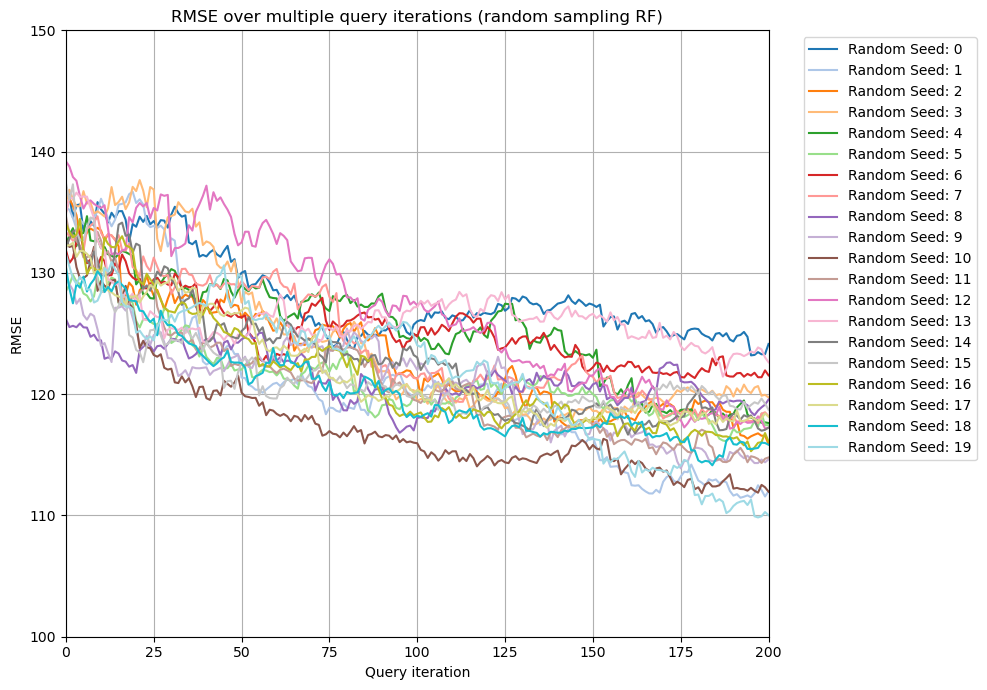

In [16]:
from copy import deepcopy
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import root_mean_squared_error
from modAL.models import ActiveLearner, CommitteeRegressor

# initial training data
X_pool_original = deepcopy(X_TRAIN).to_numpy()
y_pool_original = deepcopy(y_TRAIN).to_numpy()

# test data
X_test = deepcopy(X_TEST).to_numpy()
y_test = deepcopy(y_TEST).to_numpy()

# initializing of committee
n_members = 5
n_initial = 45  # random samples from the pool (randomly selected)

# Results are stored in a dictionary
rsme_results = {}
# number of iterations
iterations = 20

for i in range(iterations):
    print(f"Current iteration: {i}")

    # set random seed
    np.random.seed(i)

    # store all the members of the initialized committee
    learner_list = []

    # create a deep copy of the pool to ensure that the original data is not altered
    # and to ensure that all initial sizes and committee sizes are tested with the whole pool!
    X_pool = deepcopy(X_pool_original)
    y_pool = deepcopy(y_pool_original)

    # list of indices where random samples are choosen for initialization
    remaining_idx = list(range(len(X_pool)))  # generates list of indices

    for member_idx in range(
        n_members
    ):  # each iteration of the loop trains a new member of the committee

        # Stop if not enough samples remain for the required number of initial samples
        if len(remaining_idx) < n_initial:
            break

        # Generate random indices for training data selection from remaining indices
        train_idx = np.random.choice(
            remaining_idx, size=n_initial, replace=False
        )  # random indices

        # initial traning data
        X_train = X_pool[train_idx]
        y_train = y_pool[train_idx]

        # initializing the learner
        learner = ActiveLearner(
            estimator=RandomForestRegressor(
                n_estimators=120,
                min_samples_split=5,
                min_samples_leaf=1,
                n_jobs=50,
                random_state=i,
            ),
            X_training=X_train,
            y_training=y_train,
        )

        # Apend learner to the list of learners
        learner_list.append(learner)  # holds all members of the committee

        # Update the remaining idexes
        remaining_idx = [idx for idx in remaining_idx if idx not in train_idx]

    # Update the pool
    X_pool_remaining = X_pool[remaining_idx]
    y_pool_remaining = y_pool[remaining_idx]

    # creates the committee instance with all individual learners forming a committee
    committee = CommitteeRegressor(
        learner_list=learner_list, query_strategy=random_sampling
    )  

    # plot the initial prediction from the committee
    unqueried_y_pred = committee.predict(X_test)
    unqueried_rsme = root_mean_squared_error(y_test, unqueried_y_pred)
    # print("Root Mean Squared Error (RMSE) before active learning:", unqueried_rsme)

    # Active Learning - Query by Committee
    # number of queries:
    n_queries = 200
    rsme_values = [
        unqueried_rsme
    ]  # start with unqueries RSME before the active learning
    # Active learning loop
    for idx in range(n_queries):
        # query the committee for a new instance
        query_idx, query_instance = committee.query(X_pool_remaining)
        # teach the committee the new instance
        committee.teach(
            X_pool_remaining[query_idx], y_pool_remaining[query_idx]
        )  
        # predict the RSME based on the test set
        y_pred = committee.predict(X_test)
        rsme = root_mean_squared_error(y_test, y_pred)
        # print(f"Root Mean Squared Error (RMSE) after query {idx+1}: {rsme}")
        # append RSME value of the query to the list
        rsme_values.append(rsme)
        # delecte query from the pool
        X_pool_remaining = np.delete(
            X_pool_remaining, query_idx, axis=0
        ) 
        y_pool_remaining = np.delete(
            y_pool_remaining, query_idx
        )  

    # Store RSME values for each respective committee size
    rsme_results[i] = rsme_values

# save the results as a csv file
rsme_df = pd.DataFrame(rsme_results)
rsme_df.to_csv("RF_RSME_results_randomsampling_2.csv")

# PLOT SECTION
plt.figure(figsize=(10, 7))
cmap = plt.get_cmap("tab20")

for i, rsme_values in rsme_results.items():
    color = cmap(i / iterations)  
    plt.plot(
        range(len(rsme_values)), rsme_values, label=f"Random Seed: {i}", color=color
    )

# set title of plot
plt.title("RMSE over multiple query iterations (random sampling RF)")
# set limits of x-axis
plt.xlabel("Query iteration")
# set limits of y-axis
plt.ylabel("RMSE")
# set limits of y-axis
plt.ylim(100, 150)
# set limits of x-axis
plt.xlim(0, 200)
# add grid
plt.grid(True)
# add legend
plt.legend(loc="upper left", bbox_to_anchor=(1.04, 1))
# tight layout
plt.tight_layout()
# save plot
plt.savefig("RF_multiple_iterations_randomsampling.png")
# show plot
plt.show()

#### Support Vector Regression

##### Testing best model multiple times with varying random states (Support Vector Regression with random sampling)

Similar to the best model of the Query by Committee approach the best model of the Random Sampling approach will be tested multiple times with varying random seeds to achieve comparable results. The number of initial samples and committee members will be the kept the same as with max_std_sampling to ensure a fair comparison. The results again will be saved and exported as a csv file. 

Current iteration: 0
Current iteration: 1
Current iteration: 2
Current iteration: 3
Current iteration: 4
Current iteration: 5
Current iteration: 6
Current iteration: 7
Current iteration: 8
Current iteration: 9
Current iteration: 10
Current iteration: 11
Current iteration: 12
Current iteration: 13
Current iteration: 14
Current iteration: 15
Current iteration: 16
Current iteration: 17
Current iteration: 18
Current iteration: 19


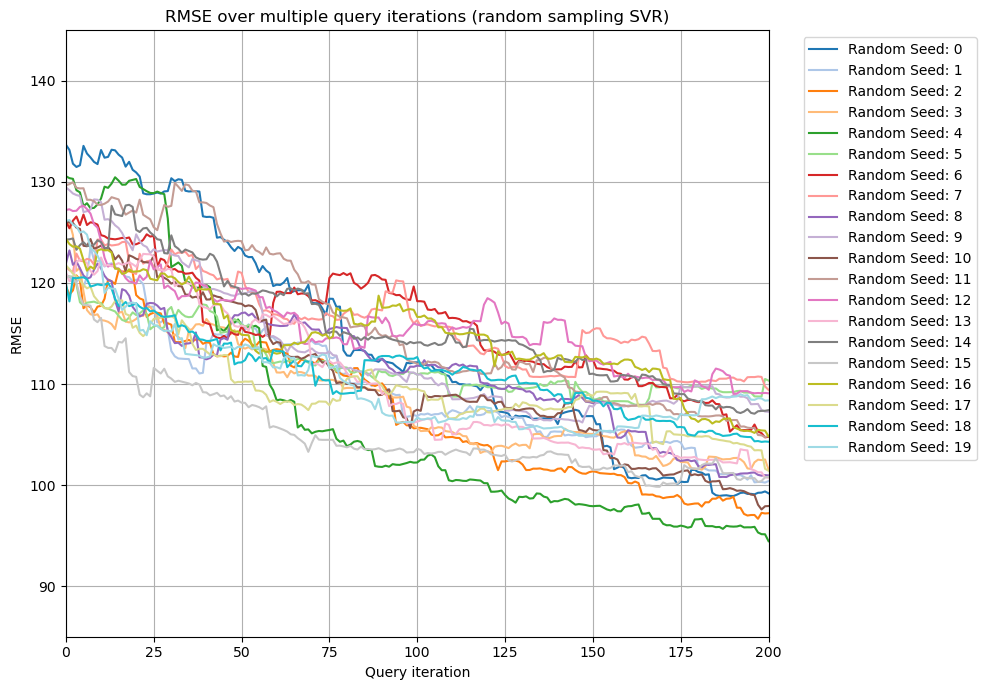

In [45]:
# when using deepcopy a fully independent copy of the object is created (otherwhise the oriiginal data could be altered)
from copy import deepcopy
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import root_mean_squared_error
from modAL.models import ActiveLearner, CommitteeRegressor

# initial training data
X_pool_unscaled = deepcopy(X_TRAIN).to_numpy()
y_pool_original = deepcopy(y_TRAIN).to_numpy()

# test data
X_test_unscaled = deepcopy(X_TEST).to_numpy()
y_test = deepcopy(y_TEST).to_numpy()

# SCALING OF DATA!
# instantiate StandardScaler
scaler = StandardScaler()

# fit the scaler to the training data
scaler.fit(X_pool_unscaled)

# transform the training data
X_pool_original = scaler.transform(X_pool_unscaled)

# transform the test data
X_test = scaler.transform(X_test_unscaled)

# initializing of committee
n_members = 4
n_initial = 50  # random samples from the pool (randomly selected)

# Results are stored in a dictionary
rsme_results = {}
# number of iterations
iterations = 20

for i in range(iterations):
    print(f"Current iteration: {i}")

    # set random seed
    np.random.seed(i)

    # store all the members of the initialized committee
    learner_list = []

    # create a deep copy of the pool to ensure that the original data is not altered
    # and to ensure that all initial sizes and committee sizes are tested with the whole pool!
    X_pool = deepcopy(X_pool_original)
    y_pool = deepcopy(y_pool_original)

    # list of indices where random samples are choosen for initialization
    remaining_idx = list(range(len(X_pool)))  # generates list of indices

    for member_idx in range(
        n_members
    ):  # each iteration of the loop trains a new member of the committee

        # Stop if not enough samples remain for the required number of initial samples
        if len(remaining_idx) < n_initial:
            break

        # Generate random indices for training data selection from remaining indices
        train_idx = np.random.choice(
            remaining_idx, size=n_initial, replace=False
        )  # random indices

        # initial traning data
        X_train = X_pool[train_idx]
        y_train = y_pool[train_idx]

        # initializing the learner
        learner = ActiveLearner(
            estimator=SVR(kernel="rbf", gamma="scale", C=3500.0, epsilon=0.01),
            X_training=X_train,
            y_training=y_train,
        )

        # Apend learner to the list of learners
        learner_list.append(learner)  # holds all members of the committee

        # Update the remaining idexes
        remaining_idx = [idx for idx in remaining_idx if idx not in train_idx]

    # Update the pool
    X_pool_remaining = X_pool[remaining_idx]
    y_pool_remaining = y_pool[remaining_idx]

    # creates the committee instance with all individual learners forming a committee
    committee = CommitteeRegressor(
        learner_list=learner_list, query_strategy=random_sampling
    )  

    # plot the initial prediction from the committee
    unqueried_y_pred = committee.predict(X_test)
    unqueried_rsme = root_mean_squared_error(y_test, unqueried_y_pred)
    # print("Root Mean Squared Error (RMSE) before active learning:", unqueried_rsme)

    # Active Learning - Query by Committee
    # number of queries:
    n_queries = 200
    rsme_values = [
        unqueried_rsme
    ]  # start with unqueries RSME before the active learning
    # Active learning loop
    for idx in range(n_queries):
        # query the committee for a new instance
        query_idx, query_instance = committee.query(X_pool_remaining)
        # teach the query to the committee
        committee.teach(
            X_pool_remaining[query_idx], y_pool_remaining[query_idx]
        )  # teach the committee the new instance
        # predict the RSME based on the test set
        y_pred = committee.predict(X_test)
        rsme = root_mean_squared_error(y_test, y_pred)
        # print(f"Root Mean Squared Error (RMSE) after query {idx+1}: {rsme}")
        # append RSME value of the query to the list
        rsme_values.append(rsme)
        # delecte query from the pool
        X_pool_remaining = np.delete(
            X_pool_remaining, query_idx, axis=0
        )  
        y_pool_remaining = np.delete(
            y_pool_remaining, query_idx
        )  

    # Store RSME values for each respective committee size
    rsme_results[i] = rsme_values

# save the results as a csv file
rsme_df = pd.DataFrame(rsme_results)
rsme_df.to_csv("SVR_RSME_results_randomsampling_2.csv")

# PLOT SECTION
plt.figure(figsize=(10, 7))
cmap = plt.get_cmap("tab20")

for i, rsme_values in rsme_results.items():
    color = cmap(i / iterations)  
    plt.plot(
        range(len(rsme_values)), rsme_values, label=f"Random Seed: {i}", color=color
    )

# set title of plot
plt.title("RMSE over multiple query iterations (random sampling SVR)")
# set limits of x-axis
plt.xlabel("Query iteration")
# set limits of y-axis
plt.ylabel("RMSE")
# set limits of y-axis
plt.ylim(85, 145)
# set limits of x-axis
plt.xlim(0, 200)
# add grid
plt.grid(True)
# add legend
plt.legend(loc="upper left", bbox_to_anchor=(1.04, 1))
# tight layout
plt.tight_layout()
# save plot
plt.savefig("SVR_multiple_iterations_randomsampling.png")
# show plot
plt.show()

### Comparison of random sampling and max std sampling (QBC)

The results of the final model, with the best committee members and initial sample size, which were computed with multiple random seeds, were saved and exported as a csv file. These files will be processed and the mean, median, and standard deviation of the results will be calculated and exported as a csv file. The mean and median of both max std sampling and random sampling will be compared for both prediction model types.

In [24]:
import pandas as pd

def process_data_csv(file):
    '''
    Process the data in the output csv file containing multiple iterations of RMSE values 
    by calculating the mean, median and standard deviation of the RMSE values and 
    saving the results in a new csv file
    '''
    # read the csv file into a dataframe
    df = pd.read_csv(file, index_col=0)

    # calculate mean, median and standard deviation
    # axis = 1 -> row-wise operation
    mean_values = df.mean(axis=1)
    median_values = df.median(axis=1)
    std_values = df.std(axis=1)

    # create a new dataframe to store the results
    results_df = pd.DataFrame(
        {
            "Mean": mean_values,
            "Median": median_values,
            "Standard Deviation": std_values,
        }
    )
    # save the dataframe into a new CSV file
    results_file = file.replace(".csv", "_processed.csv")
    results_df.to_csv(results_file)
    print(f"Saved results to {results_file}")

In [4]:
# save all files in a list of files
files = [
    "RF_RSME_results_randomsampling.csv",
    "RF_RSME_results.csv",
    "SVR_RSME_results_randomsampling.csv",
    "SVR_RSME_results.csv",
]

# process all files
for file in files:
    process_data_csv(file)

Saved results to RF_RSME_results_randomsampling_processed.csv
Saved results to RF_RSME_results_processed.csv
Saved results to SVR_RSME_results_randomsampling_processed.csv
Saved results to SVR_RSME_results_processed.csv


#### Random Forest Regression

Comparison of Mean and Median Values RF (max std sampling vs random sampling)

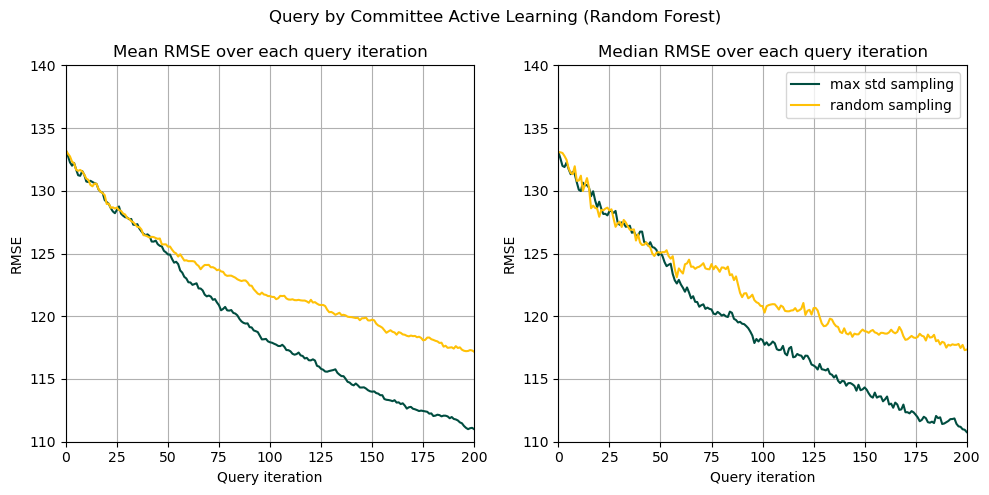

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# import the data
RF_max_std_sampling = pd.read_csv("RF_RSME_results_processed.csv")
RF_random_sampling = pd.read_csv("RF_RSME_results_randomsampling_processed.csv")

# extract mean and median values
RF_max_std_mean = RF_max_std_sampling["Mean"]
RF_max_std_median = RF_max_std_sampling["Median"]

RF_random_mean = RF_random_sampling["Mean"]
RF_random_median = RF_random_sampling["Median"]

# PLOT SECTION
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# mean values
# Plot max_std
ax[0].plot(
    range(len(RF_max_std_mean)),
    RF_max_std_mean,
    linestyle="-",
    color="#004D40",
    label="max std sampling",
)

# Plot random
ax[0].plot(
    range(len(RF_random_mean)),
    RF_random_mean,
    linestyle="-",
    color="#FFC107",
    label="random sampling",
)

ax[0].set_title("Mean RMSE over each query iteration")
ax[0].set_xlabel("Query iteration")
ax[0].set_ylabel("RMSE")
ax[0].set_xlim(0, 200)
ax[0].set_ylim(110, 140)
ax[0].grid(True)

# median values
# Plot max_std
ax[1].plot(
    range(len(RF_max_std_median)),
    RF_max_std_median,
    linestyle="-",
    color="#004D40",
    label="max std sampling",
)

# Plot random
ax[1].plot(
    range(len(RF_random_median)),
    RF_random_median,
    linestyle="-",
    color="#FFC107",
    label="random sampling",
)

ax[1].set_title("Median RMSE over each query iteration")
ax[1].set_xlabel("Query iteration")
ax[1].set_ylabel("RMSE")
ax[1].set_xlim(0, 200)
ax[1].set_ylim(110, 140)
ax[1].grid(True)

plt.suptitle("Query by Committee Active Learning (Random Forest)")
plt.legend()
plt.tight_layout()
plt.savefig("RF_QBC_max_std_vs_random_sampling_median_mean.png")
plt.show()

#### Support Vector Regression

Comparison of Mean and Median Values SVR (max std sampling vs random sampling)

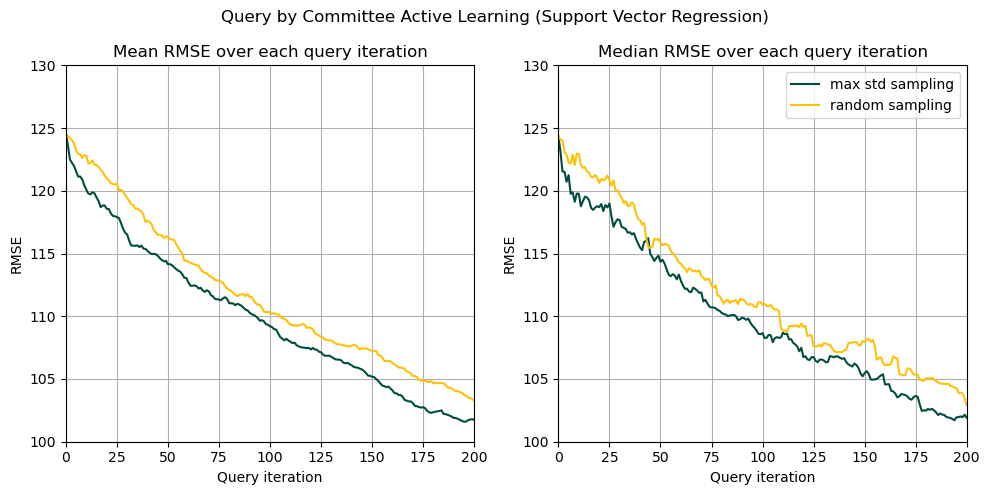

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# import the data
SVR_max_std_sampling = pd.read_csv("SVR_RSME_results_processed.csv")
SVR_random_sampling = pd.read_csv("SVR_RSME_results_randomsampling_processed.csv")

# extract mean and std dev values
SVR_max_std_median = SVR_max_std_sampling["Median"]
SVR_max_std_mean = SVR_max_std_sampling["Mean"]

SVR_random_median = SVR_random_sampling["Median"]
SVR_random_mean = SVR_random_sampling["Mean"]

# PLOT SECTION
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# mean values
# Plot max_std
ax[0].plot(
    range(len(SVR_max_std_mean)),
    SVR_max_std_mean,
    linestyle="-",
    color="#004D40",
    label="max std sampling",
)

# Plot random
ax[0].plot(
    range(len(SVR_random_mean)),
    SVR_random_mean,
    linestyle="-",
    color="#FFC107",
    label="random sampling",
)

ax[0].set_title("Mean RMSE over each query iteration")
ax[0].set_xlabel("Query iteration")
ax[0].set_ylabel("RMSE")
ax[0].set_xlim(0, 200)
ax[0].set_ylim(100, 130)
ax[0].grid(True)

# median values
# Plot max_std
ax[1].plot(
    range(len(SVR_max_std_median)),
    SVR_max_std_median,
    linestyle="-",
    color="#004D40",
    label="max std sampling",
)

# Plot random
ax[1].plot(
    range(len(SVR_random_median)),
    SVR_random_median,
    linestyle="-",
    color="#FFC107",
    label="random sampling",
)

ax[1].set_title("Median RMSE over each query iteration")
ax[1].set_xlabel("Query iteration")
ax[1].set_ylabel("RMSE")
ax[1].set_xlim(0, 200)
ax[1].set_ylim(100, 130)
ax[1].grid(True)

plt.suptitle("Query by Committee Active Learning (Support Vector Regression)")
plt.legend()
plt.tight_layout()
plt.savefig("SVR_QBC_max_std_vs_random_sampling_median_mean.png")
plt.show()

## IDEAL algorithmn

The IDEAL algorithmn in tested as an alternative to the Query by Committee approach. This algorithmn uses inverse distance weighting to select the samples for the next iteration. The IDEAL algorithmn is tested with the Random Forest Regression and the Support Vector Regression model. This part uses the ideal python package which is based on: A. Bemporad, “Active learning for regression by inverse distance weighting,” Inf. Sci. (Ny)., vol. 626, pp. 275–292, 2022. The setup and implementation of the IDEAL active learning tool were performed according to example code provided by the tool itself.

### Random Forest Model (without scaling)

#### Varying Deltas

Current delta: 0.0
N =  45/245: score = 146.42597 (training) 149.81401 (tesN =  46/245: score = 146.54947 (training) 150.04017 (tesN =  47/245: score = 141.66560 (training) 143.39772 (tesN =  48/245: score = 142.61198 (training) 143.35712 (tesN =  49/245: score = 140.59613 (training) 142.22386 (tesN =  50/245: score = 140.97608 (training) 141.97993 (tesN =  51/245: score = 139.00316 (training) 140.55754 (tesN =  52/245: score = 138.79215 (training) 139.52750 (tesN =  53/245: score = 141.99451 (training) 142.99134 (tesN =  54/245: score = 144.38845 (training) 144.02036 (tesN =  55/245: score = 139.69844 (training) 139.45588 (tesN =  56/245: score = 140.07696 (training) 141.07602 (tesN =  57/245: score = 139.17667 (training) 138.15386 (tesN =  58/245: score = 139.66909 (training) 138.03299 (tesN =  59/245: score = 138.79772 (training) 137.03519 (tesN =  60/245: score = 140.25124 (training) 139.03739 (tesN =  61/245: score = 136.83760 (training) 136.36717 (tesN =  62/245: score = 140.1134

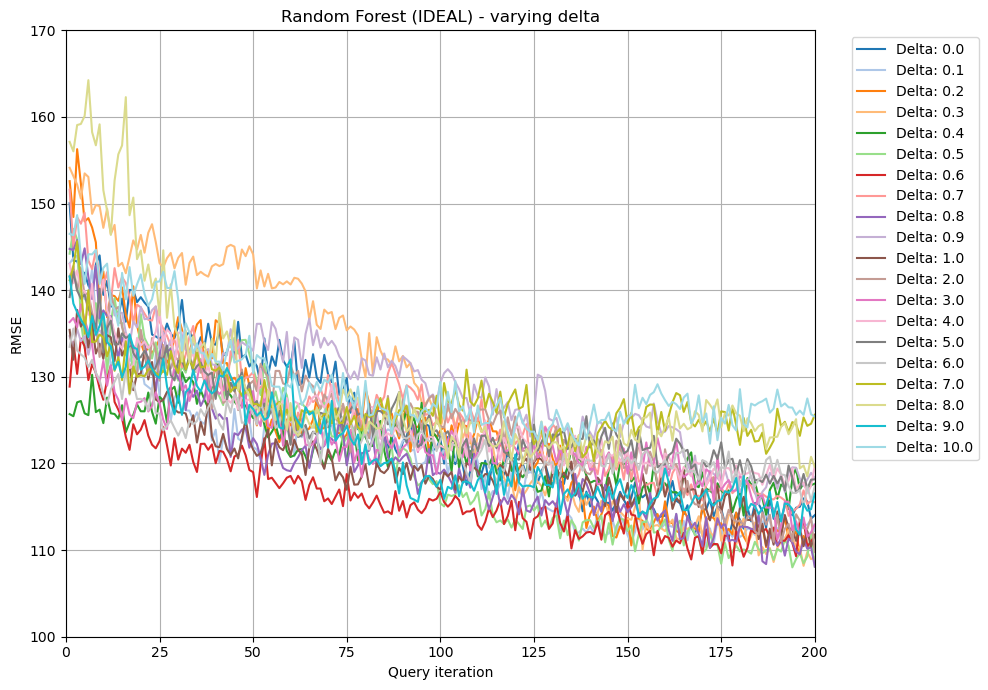

In [55]:
from ideal import ideal
from copy import deepcopy
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(42)

# initial training data
X_pool = deepcopy(X_TRAIN).to_numpy()
y_pool = deepcopy(y_TRAIN).to_numpy()

# test data
X_test = deepcopy(X_TEST).to_numpy()
y_test = deepcopy(y_TEST).to_numpy()

# initializing of committee
n_init = 45
# store results in dictionary
results = {}
# hyperparameters
pred_type = "regression"
# maximum iterations
n_iter = 200
# re-train every T_train samples
T_train = 1  
# weight on IDW function
delta = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 4.0 ,5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
# maximum number of evaluations
maxevals = n_init + n_iter

for d in delta:
    print(f"Current delta: {d}")

    pred = RandomForestRegressor(
        n_estimators=120, min_samples_split=5, min_samples_leaf=1, n_jobs=50
    )

    data = {"X": X_pool, "Y": y_pool, "X_test": X_test, "Y_test": y_test}

    trained_pred, samples, scores = ideal.ideal_training(
        data,
        pred,
        pred_type,
        delta=d,
        n_init=n_init,
        maxevals=maxevals,
        method="ideal",
        init_method="random",
        verbose=1,
    )
    results[d] = scores["test"]


# Plot section
plt.figure(figsize=(10, 7))
cmap = plt.get_cmap("tab20")
colors = cmap.colors

for idx, d in enumerate(results):
    color = colors[idx % len(colors)]
    plt.plot(
        np.arange(1, 201),
        results[d][n_init:maxevals],
        label=f"Delta: {d}",
        color = color
    )

plt.title("Random Forest (IDEAL) - varying delta")
plt.xlabel("Query iteration")
plt.ylabel("RMSE")
plt.ylim(100, 170)
plt.xlim(0, 200)
plt.grid(True)
plt.legend(loc="upper left", bbox_to_anchor=(1.04, 1))
plt.tight_layout()
plt.savefig("RF_multiple_deltas_IDEAL_1.png")
plt.show()

#### Varying Starting Sizes

Current initial sample size: 5
N =   5/205: score = 198.14495 (training) 201.32737 (tesN =   6/205: score = 189.62727 (training) 193.16104 (tesN =   7/205: score = 196.08085 (training) 202.00101 (tesN =   8/205: score = 186.18460 (training) 192.87972 (tesN =   9/205: score = 176.11211 (training) 183.95549 (tesN =  10/205: score = 181.22516 (training) 190.00447 (tesN =  11/205: score = 182.22548 (training) 186.50710 (tesN =  12/205: score = 183.94536 (training) 190.54372 (tesN =  13/205: score = 182.43526 (training) 187.59126 (tesN =  14/205: score = 172.18603 (training) 178.15097 (tesN =  15/205: score = 178.37285 (training) 184.10144 (tesN =  16/205: score = 166.31389 (training) 169.92559 (tesN =  17/205: score = 158.14918 (training) 160.52317 (tesN =  18/205: score = 156.28497 (training) 158.43410 (tesN =  19/205: score = 156.06409 (training) 158.15206 (tesN =  20/205: score = 162.63603 (training) 167.45158 (tesN =  21/205: score = 158.36443 (training) 165.16179 (tesN =  22/205: scor

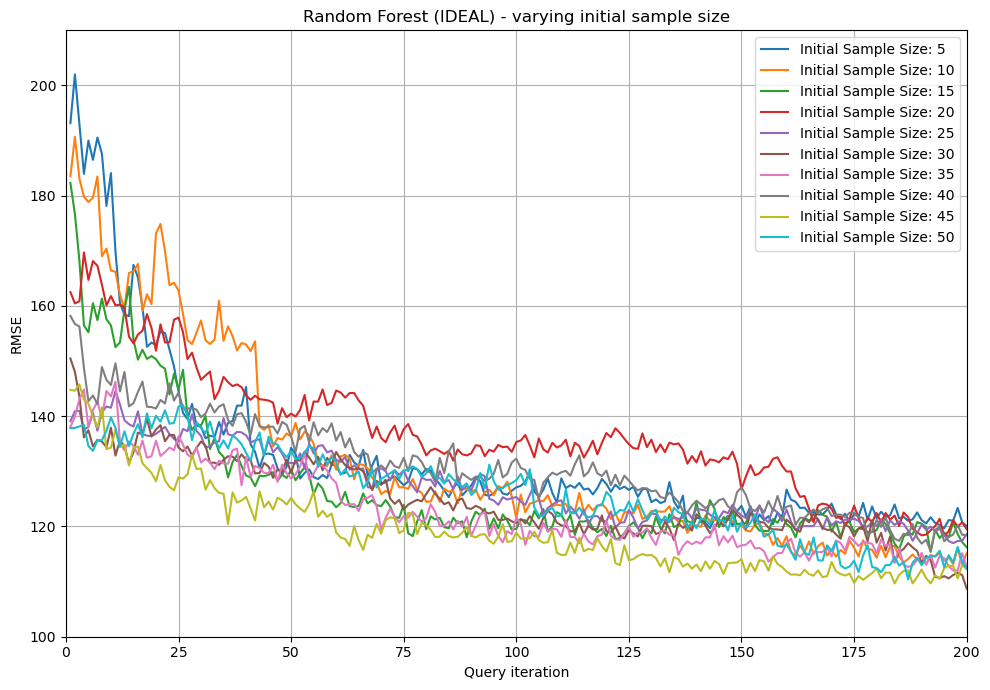

In [24]:
from ideal import ideal
from copy import deepcopy
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(42)

# initial training data
X_pool = deepcopy(X_TRAIN).to_numpy()
y_pool = deepcopy(y_TRAIN).to_numpy()

# test data
X_test = deepcopy(X_TEST).to_numpy()
y_test = deepcopy(y_TEST).to_numpy()

# initializing of committee
n_init = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
# store results in dictionary
results = {}
# hyperparameters
pred_type = "regression"
# maximum iterations
n_iter = 200
# re-train every T_train samples
T_train = 1  
# weight on IDW function
delta = 0.5

for n in n_init:
    print(f"Current initial sample size: {n}")

    maxevals = n + n_iter

    pred = RandomForestRegressor(
        n_estimators=120, min_samples_split=5, min_samples_leaf=1, n_jobs=30
    )

    data = {"X": X_pool, "Y": y_pool, "X_test": X_test, "Y_test": y_test}

    trained_pred, samples, scores = ideal.ideal_training(
        data,
        pred,
        pred_type,
        delta=delta,
        n_init=n,
        maxevals=maxevals,
        method="ideal",
        init_method="random",
        verbose=1,
    )
    results[n] = scores["test"]


# Plot section
plt.figure(figsize=(10, 7))
cmap = plt.get_cmap("tab10")
colors = cmap.colors

for idx, n in enumerate(results):
    maxevals = n + n_iter
    color = colors[idx % len(colors)]
    plt.plot(
        np.arange(1, 201),
        results[n][n:maxevals],
        label=f"Initial Sample Size: {n}",
        color=color
    )

plt.title("Random Forest (IDEAL) - varying initial sample size")
plt.xlabel("Query iteration")
plt.ylabel("RMSE")
plt.ylim(100, 210)
plt.xlim(0, 200)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("RF_multiple_initial_samples_IDEAL.png")
plt.show()

#### Varying random seeds

Current iteration: 0


N =  45/245: score = 132.39533 (training) 135.65516 (tesN =  46/245: score = 132.32817 (training) 136.30589 (tesN =  47/245: score = 132.69302 (training) 136.22156 (tesN =  48/245: score = 132.32580 (training) 135.74554 (tesN =  49/245: score = 132.42725 (training) 136.05503 (tesN =  50/245: score = 134.25434 (training) 140.26992 (tesN =  51/245: score = 133.82660 (training) 139.20450 (tesN =  52/245: score = 135.82327 (training) 141.56620 (tesN =  53/245: score = 132.73159 (training) 139.09008 (tesN =  54/245: score = 132.45827 (training) 139.12786 (tesN =  55/245: score = 130.80444 (training) 135.93561 (tesN =  56/245: score = 129.62931 (training) 134.34661 (tesN =  57/245: score = 131.27939 (training) 135.14697 (tesN =  58/245: score = 130.34297 (training) 134.48865 (tesN =  59/245: score = 130.19551 (training) 134.15854 (tesN =  60/245: score = 130.67640 (training) 133.80838 (tesN =  61/245: score = 131.28695 (training) 134.61898 (tesN =  62/245: score = 130.48929 (training) 134.42

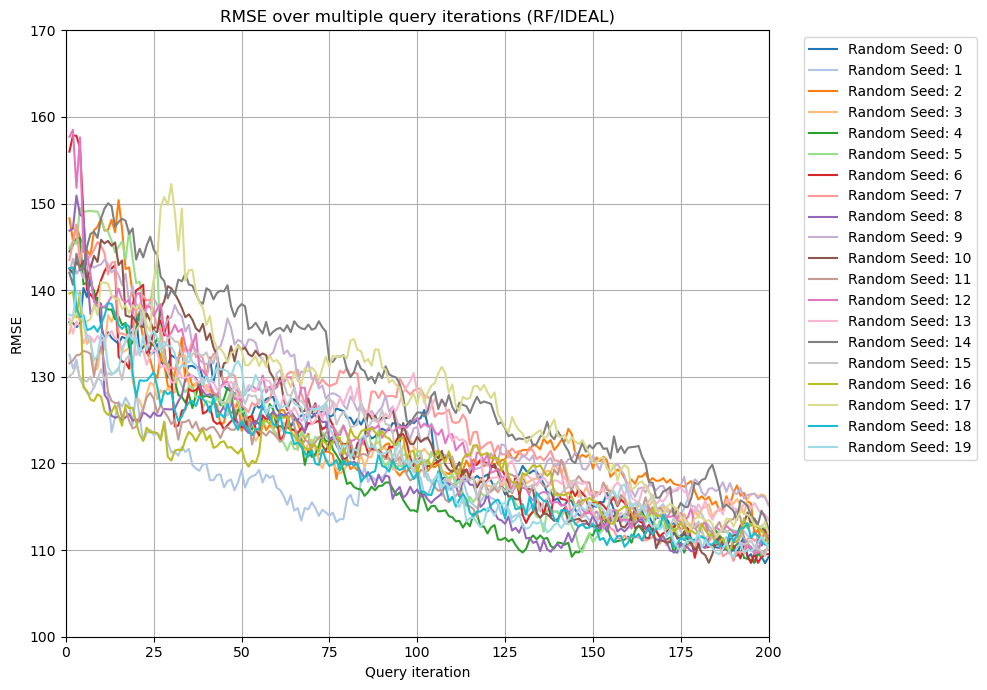

In [34]:
from ideal import ideal
from copy import deepcopy
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import numpy as np

# initial training data
X_pool = deepcopy(X_TRAIN).to_numpy()
y_pool = deepcopy(y_TRAIN).to_numpy()

# test data
X_test = deepcopy(X_TEST).to_numpy()
y_test = deepcopy(y_TEST).to_numpy()

# re-train predictor every T_train samples
T_train = 1
# weight on IDW function
delta = 0.5
# initializing of committee
n_init = 45
# store results in dictionary
results = {}
# hyperparameters
pred_type = "regression"
# maximum iterations
n_iter = 200
# total iterations
maxevals = n_init + n_iter
# number of iterations (random seeds)
iterations = 20

for i in range(iterations):
    print(f"Current iteration: {i}")

    # set random seed
    np.random.seed(i)

    pred = RandomForestRegressor(
        n_estimators=120,
        min_samples_split=5,
        min_samples_leaf=1,
        n_jobs=30,
        random_state=i,
    )

    data = {"X": X_pool, "Y": y_pool, "X_test": X_test, "Y_test": y_test}

    trained_pred, samples, scores = ideal.ideal_training(
        data,
        pred,
        pred_type,
        delta=delta,
        n_init=n_init,
        maxevals=maxevals,
        method="ideal",
        init_method="random",
        verbose=1,
    )
    results[i] = scores["test"]

# save the results as a csv file
rsme_df = pd.DataFrame(results)
rsme_df.to_csv("RF_RSME_results_IDEAL_2.csv")

# Plot section
plt.figure(figsize=(10, 7))
cmap = plt.get_cmap("tab20")

for i, scores["test"] in results.items():
    color = cmap(i / iterations)  # color map
    plt.plot(
        np.arange(1, 201),
        scores["test"][n_init:maxevals],
        label=f"Random Seed: {i}",
        color=color,
    )

plt.title("RMSE over multiple query iterations (RF/IDEAL)")
plt.xlabel("Query iteration")
plt.ylabel("RMSE")
plt.ylim(100, 170)
plt.xlim(0, 200)
plt.legend(loc="upper left", bbox_to_anchor=(1.04, 1))
plt.tight_layout()
plt.grid(True)
plt.savefig("RF_multiple_iterations_IDEAL_2.png")
plt.show()

### SVR (with scaling)

#### Varying Deltas

Current Delta: 0.0
N =  50/250: score = 126.23896 (training) 128.37621 (tesN =  51/250: score = 126.23022 (training) 128.27149 (tesN =  52/250: score = 125.98246 (training) 128.14212 (tesN =  53/250: score = 123.54701 (training) 129.42503 (tesN =  54/250: score = 125.86922 (training) 130.57238 (tesN =  55/250: score = 127.05207 (training) 131.57918 (tesN =  56/250: score = 126.66602 (training) 130.96709 (tesN =  57/250: score = 126.63951 (training) 131.18631 (tesN =  58/250: score = 126.69374 (training) 131.21850 (tesN =  59/250: score = 126.61720 (training) 130.98577 (tesN =  60/250: score = 125.10696 (training) 129.00250 (tesN =  61/250: score = 125.65346 (training) 126.91677 (tesN =  62/250: score = 126.41676 (training) 130.04014 (tesN =  63/250: score = 126.31008 (training) 129.76017 (tesN =  64/250: score = 126.45707 (training) 129.75153 (tesN =  65/250: score = 125.70463 (training) 129.34626 (tesN =  66/250: score = 127.14764 (training) 130.05326 (tesN =  67/250: score = 127.5241

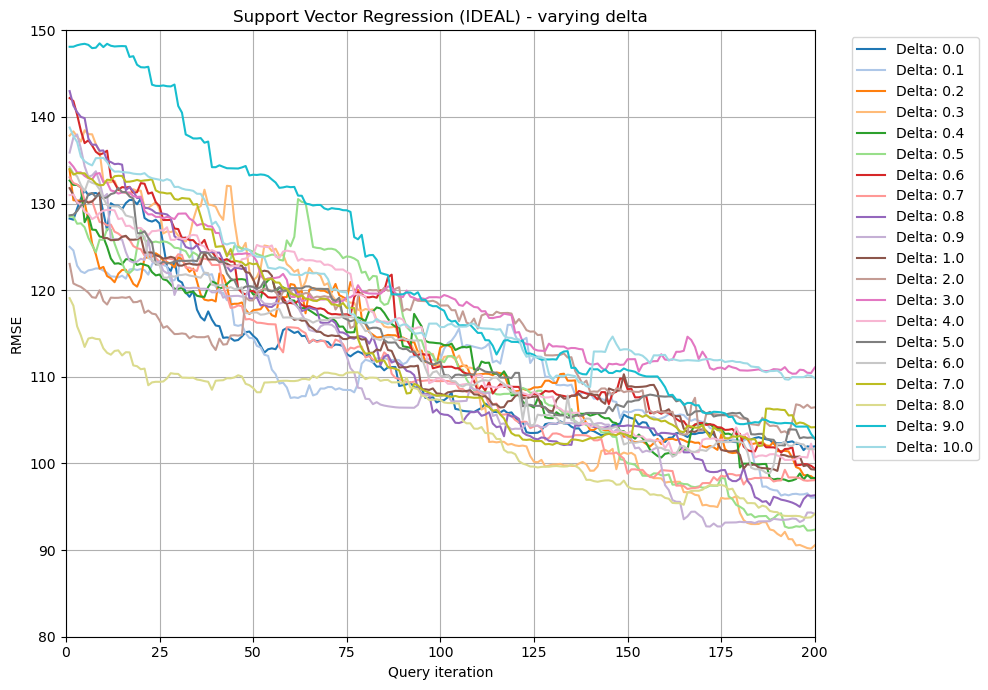

In [46]:
from ideal import ideal
from copy import deepcopy
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(18)

# initial training data
X_pool_unscaled = deepcopy(X_TRAIN).to_numpy()
y_pool = deepcopy(y_TRAIN).to_numpy()

# test data
X_test_unscaled = deepcopy(X_TEST).to_numpy()
y_test = deepcopy(y_TEST).to_numpy()

# SCALING OF DATA!
# Instantiate StandardScaler
scaler = StandardScaler()

# Fit the scaler to your training data
scaler.fit(X_pool_unscaled)

# Transform the training data
X_pool = scaler.transform(X_pool_unscaled)

# Transform the test data
X_test = scaler.transform(X_test_unscaled)

# initial model
n_init = 50
# store results in dictionary
results = {}
# hyperparameters
pred_type = "regression"
# re-train every T_train samples
T_train = 1  
# weight on IDW function
delta = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 4.0 ,5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
# maximum iterations
n_iter = 200
# max number of evaluations
maxevals = n_init + n_iter

for d in delta:
    print(f"Current Delta: {d}")

    pred = SVR(kernel="rbf", gamma="scale", C=3500.0, epsilon=0.01)

    data = {"X": X_pool, "Y": y_pool, "X_test": X_test, "Y_test": y_test}

    trained_pred, samples, scores = ideal.ideal_training(
        data,
        pred,
        pred_type,
        delta=d,
        n_init=n_init,
        maxevals=maxevals,
        method="ideal",
        init_method="random",
        verbose=1,
    )
    results[d] = scores["test"]


# Plot section
plt.figure(figsize=(10, 7))
cmap = plt.get_cmap("tab20")
colors = cmap.colors

#for d, scores["test"] in results.items():
for idx, d in enumerate(results):
    color = colors[idx % len(colors)]
    plt.plot(
        np.arange(1, 201),
        results[d][n_init:maxevals],
        label=f"Delta: {d}",
        color = color
    )


plt.title("Support Vector Regression (IDEAL) - varying delta")
plt.xlabel("Query iteration")
plt.ylabel("RMSE")
plt.ylim(80, 150)
plt.xlim(0, 200)
plt.grid(True)
plt.legend(loc="upper left", bbox_to_anchor=(1.04, 1))
plt.tight_layout()
plt.savefig("SVR_multiple_deltas_IDEAL_1.png")
plt.show()


#### Varying Starting Sizes

Current initial sample size: 5
N =   5/205: score = 181.31947 (training) 185.55870 (tesN =   6/205: score = 176.86899 (training) 181.39892 (tesN =   7/205: score = 168.64628 (training) 173.21464 (tesN =   8/205: score = 168.32626 (training) 172.70360 (tesN =   9/205: score = 172.71833 (training) 175.70454 (tesN =  10/205: score = 180.23359 (training) 182.98803 (tesN =  11/205: score = 173.97206 (training) 177.28332 (tesN =  12/205: score = 175.27395 (training) 178.86487 (tesN =  13/205: score = 153.63544 (training) 158.49866 (tesN =  14/205: score = 149.47035 (training) 154.06608 (tesN =  15/205: score = 154.35398 (training) 160.24799 (tesN =  16/205: score = 151.83514 (training) 157.19466 (tesN =  17/205: score = 151.34721 (training) 156.83725 (tesN =  18/205: score = 151.66017 (training) 157.08107 (tesN =  19/205: score = 152.34846 (training) 157.51985 (tesN =  20/205: score = 148.37447 (training) 152.22206 (tesN =  21/205: score = 144.99857 (training) 148.00343 (tesN =  22/205: scor

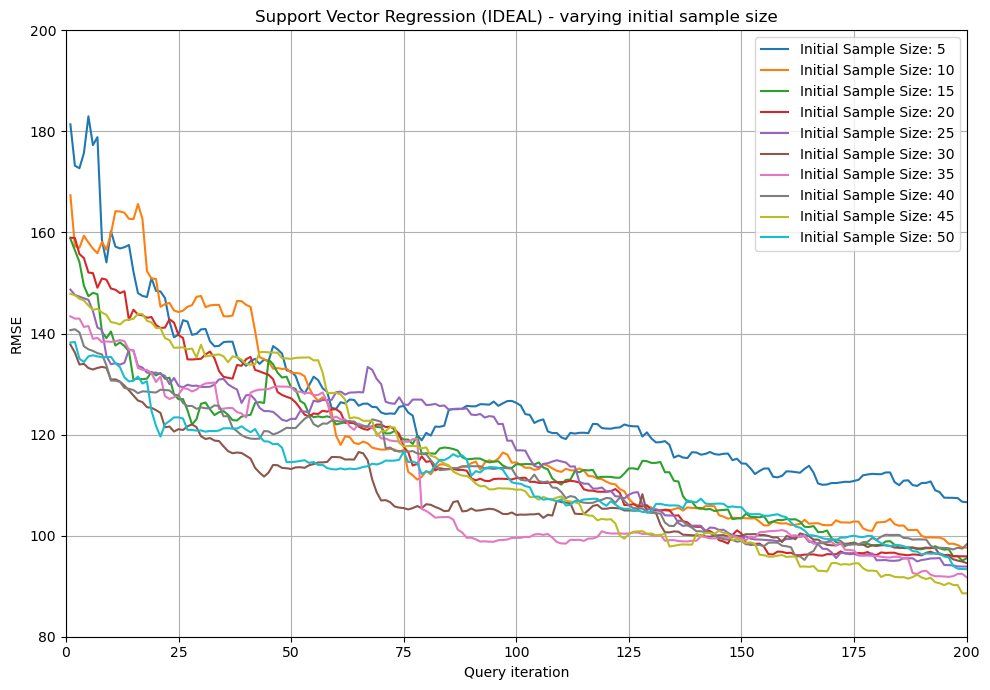

In [32]:
from ideal import ideal
from copy import deepcopy
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(18)

# initial training data
X_pool_unscaled = deepcopy(X_TRAIN).to_numpy()
y_pool = deepcopy(y_TRAIN).to_numpy()

# test data
X_test_unscaled = deepcopy(X_TEST).to_numpy()
y_test = deepcopy(y_TEST).to_numpy()

# SCALING OF DATA!
# instantiate StandardScaler
scaler = StandardScaler()

# fit the scaler to the training data
scaler.fit(X_pool_unscaled)

# transform the training data
X_pool = scaler.transform(X_pool_unscaled)

# transform the test data
X_test = scaler.transform(X_test_unscaled)

# initial model
n_init = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
# store results in dictionary
results = {}
# hyperparameters
pred_type = "regression"
# re-train every T_train samples
T_train = 1  
# weight on IDW function
delta = 0.3
# maximum iterations
n_iter = 200

for n in n_init:
    print(f"Current initial sample size: {n}")

    maxevals = n + n_iter

    pred = SVR(kernel="rbf", gamma="scale", C=3500.0, epsilon=0.01)

    data = {"X": X_pool, "Y": y_pool, "X_test": X_test, "Y_test": y_test}

    trained_pred, samples, scores = ideal.ideal_training(
        data,
        pred,
        pred_type,
        delta=delta,
        n_init=n,
        maxevals=maxevals,
        method="ideal",
        init_method="random",
        verbose=1,
    )
    results[n] = scores["test"]


# Plot section
plt.figure(figsize=(10, 7))
cmap = plt.get_cmap("tab10")
colors = cmap.colors

for idx, n in enumerate(results):
    maxevals = n + n_iter
    color = colors[idx % len(colors)]
    plt.plot(
        np.arange(1, 201),
        results[n][n:maxevals],
        label=f"Initial Sample Size: {n}",
        color=color
    )

plt.title("Support Vector Regression (IDEAL) - varying initial sample size")
plt.xlabel("Query iteration")
plt.ylabel("RMSE")
plt.ylim(80, 200)
plt.xlim(0, 200)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("SVR_multiple_initial_samples_IDEAL.png")
plt.show()

#### Varying random seeds

Current iteration: 0
N =  50/250: score = 124.77759 (training) 124.24332 (tesN =  51/250: score = 122.32579 (training) 122.96459 (tesN =  52/250: score = 121.16651 (training) 122.26004 (tesN =  53/250: score = 120.42010 (training) 121.73987 (tesN =  54/250: score = 120.25718 (training) 121.78299 (tesN =  55/250: score = 120.62424 (training) 123.04780 (tesN =  56/250: score = 119.68982 (training) 122.27611 (tesN =  57/250: score = 118.81209 (training) 121.36916 (tesN =  58/250: score = 118.82850 (training) 121.31227 (tesN =  59/250: score = 118.58841 (training) 120.99360 (tesN =  60/250: score = 118.54836 (training) 120.99731 (tesN =  61/250: score = 119.47018 (training) 121.93532 (tesN =  62/250: score = 119.38508 (training) 121.93200 (tesN =  63/250: score = 118.36649 (training) 121.35486 (tesN =  64/250: score = 118.39815 (training) 121.79506 (tesN =  65/250: score = 118.52463 (training) 121.88536 (tesN =  66/250: score = 118.71696 (training) 122.09372 (tesN =  67/250: score = 117.97

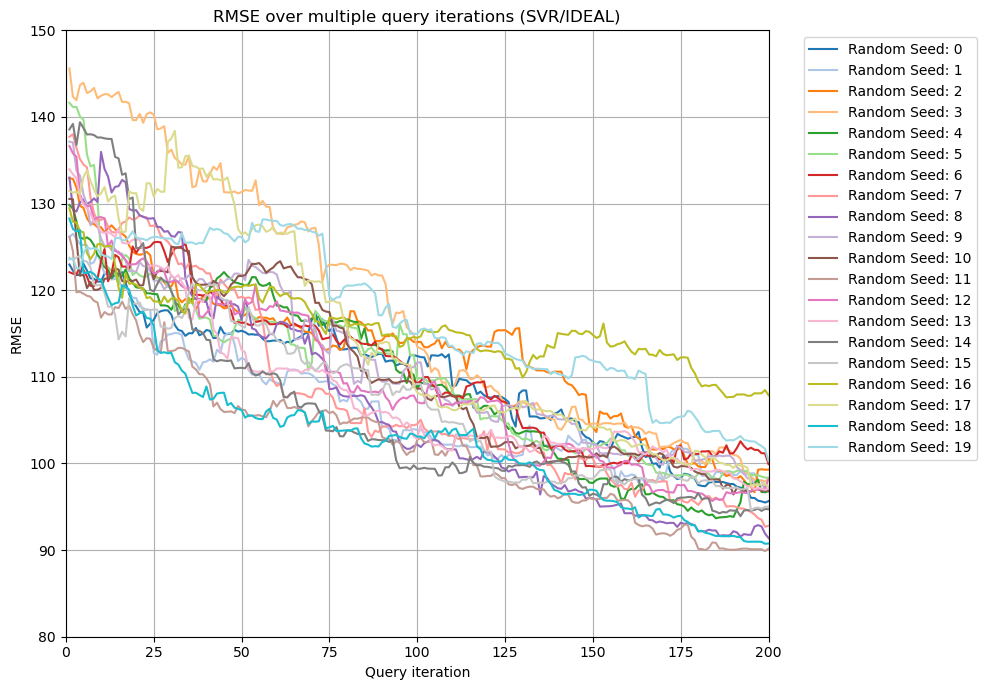

In [31]:
from ideal import ideal
from copy import deepcopy
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

# initial training data
X_pool_unscaled = deepcopy(X_TRAIN).to_numpy()
y_pool = deepcopy(y_TRAIN).to_numpy()

# test data
X_test_unscaled = deepcopy(X_TEST).to_numpy()
y_test = deepcopy(y_TEST).to_numpy()

# SCALING OF DATA!
# Instantiate StandardScaler
scaler = StandardScaler()

# Fit the scaler to your training data
scaler.fit(X_pool_unscaled)

# Transform the training data
X_pool = scaler.transform(X_pool_unscaled)

# Transform the test data
X_test = scaler.transform(X_test_unscaled)

# re-train predictor every T_train samples
T_train = 1
# weight on IDW function
delta = 0.3
# initializing of committee
n_init = 50
# store results in dictionary
results = {}
# hyperparameters
pred_type = "regression"
# maximum iterations
n_iter = 200
# total iterations
maxevals = n_init + n_iter
# number of iterations (random seeds)
iterations = 20

for i in range(iterations):
    print(f"Current iteration: {i}")

    # set random seed
    np.random.seed(i)

    pred = SVR(kernel="rbf", gamma="scale", C=3500.0, epsilon=0.01)

    data = {"X": X_pool, "Y": y_pool, "X_test": X_test, "Y_test": y_test}

    trained_pred, samples, scores = ideal.ideal_training(
        data,
        pred,
        pred_type,
        delta=delta,
        n_init=n_init,
        maxevals=maxevals,
        method="ideal",
        init_method="random",
        verbose=1,
    )
    results[i] = scores["test"]

# save the results as a csv file
rsme_df = pd.DataFrame(results)
rsme_df.to_csv("SVR_RSME_results_IDEAL.csv")


# Plot section
plt.figure(figsize=(10, 7))
cmap = plt.get_cmap("tab20")

for i, scores["test"] in results.items():
    color = cmap(i / iterations)  # color map
    plt.plot(
        np.arange(1, 201),
        scores["test"][n_init:maxevals],
        label=f"Random Seed: {i}",
        color=color,
    )

plt.title("RMSE over multiple query iterations (SVR/IDEAL)")
plt.xlabel("Query iteration")
plt.ylabel("RMSE")
plt.ylim(80, 150)
plt.xlim(0, 200)
plt.legend(loc="upper left", bbox_to_anchor=(1.04, 1))
plt.tight_layout()
plt.grid(True)
plt.savefig("SVR_multiple_iterations_IDEAL.png")
plt.show()

### Random Sampling using IDEAL (RF)

#### Varying Starting Sizes

Current initial sample size: 5
N =   5/205: score = 198.14495 (training) 201.32737 (tesN =   6/205: score = 189.20762 (training) 191.75272 (tesN =   7/205: score = 184.82247 (training) 188.19949 (tesN =   8/205: score = 176.72581 (training) 180.02071 (tesN =   9/205: score = 177.77633 (training) 181.72075 (tesN =  10/205: score = 175.42548 (training) 178.35467 (tesN =  11/205: score = 184.64378 (training) 188.54246 (tesN =  12/205: score = 184.80486 (training) 189.24146 (tesN =  13/205: score = 180.13770 (training) 183.55596 (tesN =  14/205: score = 177.17513 (training) 182.44636 (tesN =  15/205: score = 171.53767 (training) 175.82981 (tesN =  16/205: score = 165.16842 (training) 169.35675 (tesN =  17/205: score = 169.79544 (training) 174.27702 (tesN =  18/205: score = 167.07583 (training) 170.56467 (tesN =  19/205: score = 164.56595 (training) 168.07950 (tesN =  20/205: score = 167.35426 (training) 171.61102 (tesN =  21/205: score = 164.91050 (training) 167.68580 (tesN =  22/205: scor

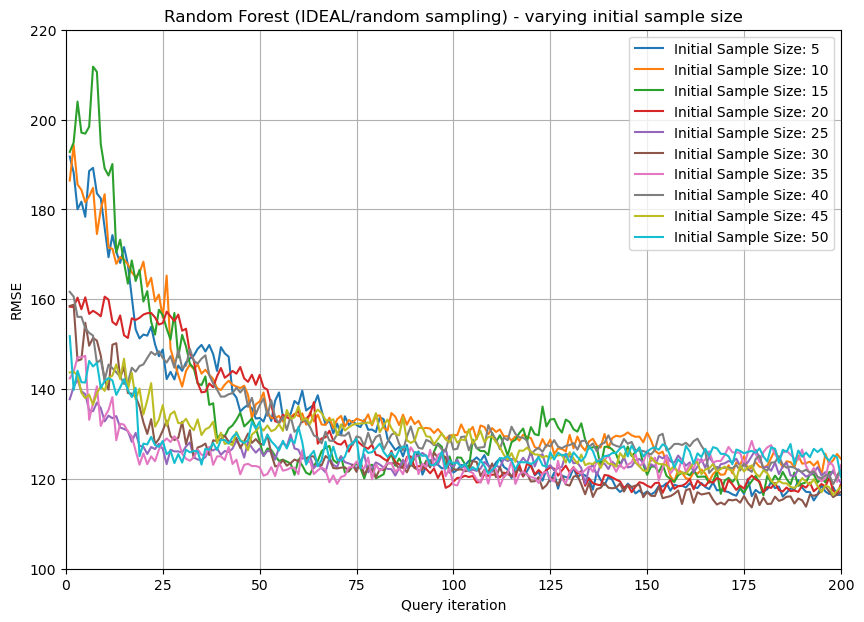

In [51]:
from ideal import ideal
from copy import deepcopy
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(42)

# initial training data
X_pool = deepcopy(X_TRAIN).to_numpy()
y_pool = deepcopy(y_TRAIN).to_numpy()

# test data
X_test = deepcopy(X_TEST).to_numpy()
y_test = deepcopy(y_TEST).to_numpy()

# initializing of committee
n_init = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
# store results in dictionary
results = {}
# hyperparameters
pred_type = "regression"
# maximum iterations
n_iter = 200
T_train = 1  # re-train every T_train samples
delta = 0.5

for n in n_init:
    print(f"Current initial sample size: {n}")

    maxevals = n + n_iter

    pred = RandomForestRegressor(
        n_estimators=120, min_samples_split=5, min_samples_leaf=1, n_jobs=50
    )

    data = {"X": X_pool, "Y": y_pool, "X_test": X_test, "Y_test": y_test}

    trained_pred, samples, scores = ideal.ideal_training(
        data,
        pred,
        pred_type,
        delta=5.0,
        n_init=n,
        maxevals=maxevals,
        method="random",
        init_method="random",
        verbose=1,
    )
    results[n] = scores["test"]


# Plot section
plt.figure(figsize=(10, 7))

for n, scores["test"] in results.items():
    maxevals = n + n_iter
    plt.plot(
        np.arange(1, 201),
        scores["test"][n:maxevals],
        label=f"Initial Sample Size: {n}",
    )

plt.title("Random Forest (IDEAL/random sampling) - varying initial sample size")
plt.xlabel("Query iteration")
plt.ylabel("RMSE")
plt.ylim(100, 220)
plt.xlim(0, 200)
plt.grid(True)
plt.legend()
plt.draw()
plt.show()

#### Varying random seeds

Current iteration: 0
N =  45/245: score = 132.39533 (training) 135.65516 (tesN =  46/245: score = 125.35463 (training) 127.70790 (tesN =  47/245: score = 126.13737 (training) 128.04308 (tesN =  48/245: score = 125.58354 (training) 127.57472 (tesN =  49/245: score = 125.37761 (training) 127.05319 (tesN =  50/245: score = 125.66496 (training) 127.55702 (tesN =  51/245: score = 126.23373 (training) 127.86576 (tesN =  52/245: score = 125.76641 (training) 128.70675 (tesN =  53/245: score = 125.64413 (training) 127.32937 (tesN =  54/245: score = 124.77764 (training) 126.24048 (tesN =  55/245: score = 126.52932 (training) 127.28609 (tesN =  56/245: score = 127.09482 (training) 127.96794 (tesN =  57/245: score = 127.02394 (training) 126.97552 (tesN =  58/245: score = 127.03770 (training) 127.09907 (tesN =  59/245: score = 126.00297 (training) 126.58527 (tesN =  60/245: score = 126.65167 (training) 127.79158 (tesN =  61/245: score = 127.48066 (training) 128.88387 (tesN =  62/245: score = 127.29

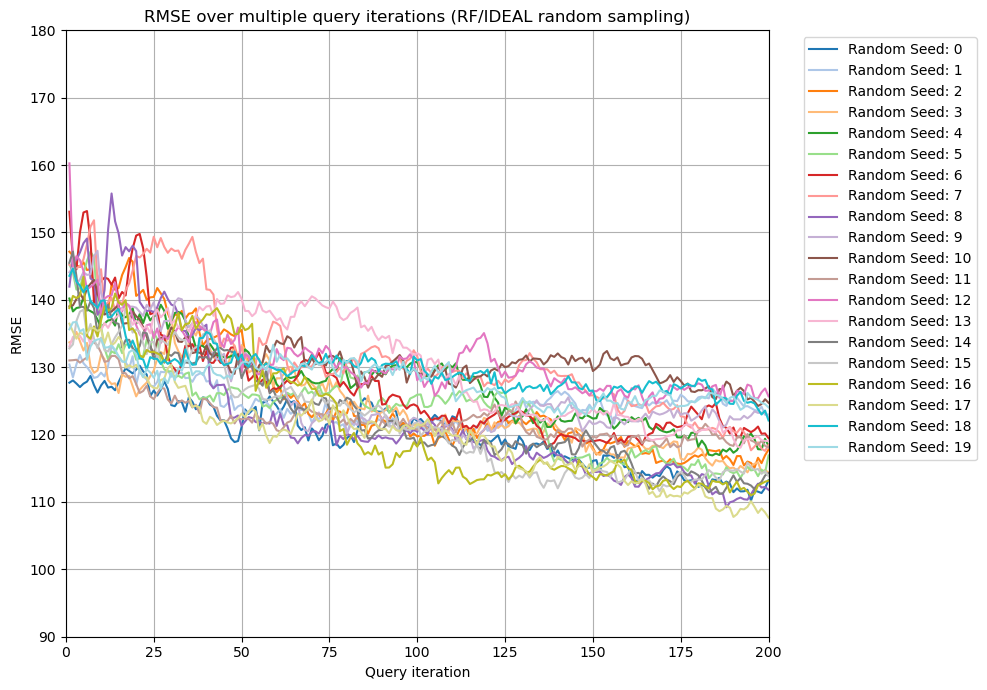

In [52]:
from ideal import ideal
from copy import deepcopy
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import numpy as np

# initial training data
X_pool = deepcopy(X_TRAIN).to_numpy()
y_pool = deepcopy(y_TRAIN).to_numpy()

# test data
X_test = deepcopy(X_TEST).to_numpy()
y_test = deepcopy(y_TEST).to_numpy()

# re-train predictor every T_train samples
T_train = 1
# weight on IDW function
delta = 0.5
# initializing of committee
n_init = 45
# store results in dictionary
results = {}
# hyperparameters
pred_type = "regression"
# maximum iterations
n_iter = 200
# total iterations
maxevals = n_init + n_iter
# number of iterations (random seeds)
iterations = 20

for i in range(iterations):
    print(f"Current iteration: {i}")

    # set random seed
    np.random.seed(i)

    pred = RandomForestRegressor(
        n_estimators=120,
        min_samples_split=5,
        min_samples_leaf=1,
        n_jobs=30,
        random_state=i,
    )

    data = {"X": X_pool, "Y": y_pool, "X_test": X_test, "Y_test": y_test}

    trained_pred, samples, scores = ideal.ideal_training(
        data,
        pred,
        pred_type,
        delta=delta,
        n_init=n_init,
        maxevals=maxevals,
        method="random",
        init_method="random",
        verbose=1,
    )
    results[i] = scores["test"]

# save the results as a csv file
rsme_df = pd.DataFrame(results)
rsme_df.to_csv("RF_RSME_results_IDEAL_randomsampling_2.csv")


# Plot section
plt.figure(figsize=(10, 7))
cmap = plt.get_cmap("tab20")

for i, scores["test"] in results.items():
    color = cmap(i / iterations)  # color map
    plt.plot(
        np.arange(1, 201),
        scores["test"][n_init:maxevals],
        label=f"Random Seed: {i}",
        color=color,
    )

plt.title("RMSE over multiple query iterations (RF/IDEAL random sampling)")
plt.xlabel("Query iteration")
plt.ylabel("RMSE")
plt.ylim(90, 180)
plt.xlim(0, 200)
plt.legend(loc="upper left", bbox_to_anchor=(1.04, 1))
plt.tight_layout()
plt.grid(True)
plt.savefig("RF_multiple_iterations_IDEAL_randomsampling.png")
plt.show()

### Random Sampling using IDEAL (SVR)

#### Varying Starting Sizes

Current initial sample size: 5
N =   5/205: score = 181.31947 (training) 185.55870 (tesN =   6/205: score = 176.29633 (training) 181.37558 (tesN =   7/205: score = 175.70330 (training) 180.65251 (tesN =   8/205: score = 173.83296 (training) 178.78238 (tesN =   9/205: score = 176.49483 (training) 180.68767 (tesN =  10/205: score = 166.47314 (training) 168.94751 (tesN =  11/205: score = 166.64763 (training) 168.53497 (tesN =  12/205: score = 164.15128 (training) 166.77860 (tesN =  13/205: score = 152.14018 (training) 154.48901 (tesN =  14/205: score = 151.80753 (training) 154.02735 (tesN =  15/205: score = 152.15091 (training) 153.93526 (tesN =  16/205: score = 152.56523 (training) 154.43374 (tesN =  17/205: score = 151.93896 (training) 153.67782 (tesN =  18/205: score = 152.05522 (training) 153.68215 (tesN =  19/205: score = 142.96079 (training) 143.03722 (tesN =  20/205: score = 142.89927 (training) 143.31724 (tesN =  21/205: score = 140.88263 (training) 143.22108 (tesN =  22/205: scor

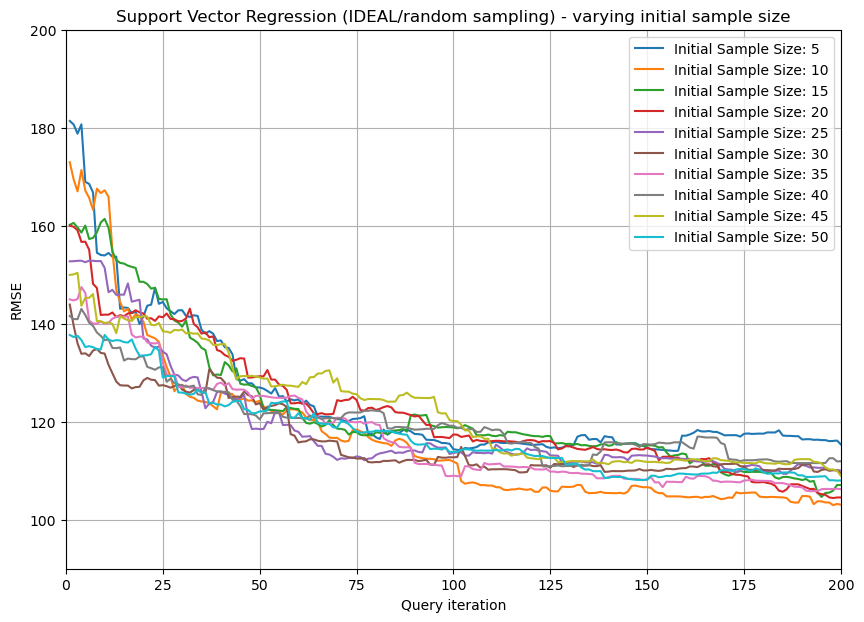

In [53]:
from ideal import ideal
from copy import deepcopy
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(18)

# initial training data
X_pool_unscaled = deepcopy(X_TRAIN).to_numpy()
y_pool = deepcopy(y_TRAIN).to_numpy()

# test data
X_test_unscaled = deepcopy(X_TEST).to_numpy()
y_test = deepcopy(y_TEST).to_numpy()

# SCALING OF DATA!
# Instantiate StandardScaler
scaler = StandardScaler()

# Fit the scaler to your training data
scaler.fit(X_pool_unscaled)

# Transform the training data
X_pool = scaler.transform(X_pool_unscaled)

# Transform the test data
X_test = scaler.transform(X_test_unscaled)

# initializing of committee
n_init = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
# store results in dictionary
results = {}
# hyperparameters
pred_type = "regression"
T_train = 1  # re-train every T_train samples
delta = 0.3
# maximum iterations
n_iter = 200

for n in n_init:
    print(f"Current initial sample size: {n}")

    maxevals = n + n_iter

    pred = SVR(kernel="rbf", gamma="scale", C=3500.0, epsilon=0.01)

    data = {"X": X_pool, "Y": y_pool, "X_test": X_test, "Y_test": y_test}

    trained_pred, samples, scores = ideal.ideal_training(
        data,
        pred,
        pred_type,
        delta=5.0,
        n_init=n,
        maxevals=maxevals,
        method="random",
        init_method="random",
        verbose=1,
    )
    results[n] = scores["test"]


# Plot section
plt.figure(figsize=(10, 7))

for n, scores["test"] in results.items():
    maxevals = n + 200
    plt.plot(
        np.arange(1, 201),
        scores["test"][n:maxevals],
        label=f"Initial Sample Size: {n}",
    )

plt.title("Support Vector Regression (IDEAL/random sampling) - varying initial sample size")
plt.xlabel("Query iteration")
plt.ylabel("RMSE")
plt.ylim(90, 200)
plt.xlim(0, 200)
plt.grid(True)
plt.legend()
plt.draw()
plt.show()

#### Varying random seeds

Current iteration: 0
N =  50/250: score = 124.77759 (training) 124.24332 (tesN =  51/250: score = 123.36219 (training) 122.68700 (tesN =  52/250: score = 123.00398 (training) 122.44813 (tesN =  53/250: score = 122.44445 (training) 121.71350 (tesN =  54/250: score = 122.35313 (training) 121.60884 (tesN =  55/250: score = 121.89863 (training) 121.35907 (tesN =  56/250: score = 123.00748 (training) 123.52686 (tesN =  57/250: score = 123.38594 (training) 123.92453 (tesN =  58/250: score = 123.11577 (training) 124.30545 (tesN =  59/250: score = 122.99363 (training) 124.25324 (tesN =  60/250: score = 123.05286 (training) 124.30300 (tesN =  61/250: score = 123.46741 (training) 124.83167 (tesN =  62/250: score = 124.08049 (training) 125.78901 (tesN =  63/250: score = 123.89278 (training) 125.84777 (tesN =  64/250: score = 123.85737 (training) 125.78988 (tesN =  65/250: score = 123.24943 (training) 124.83457 (tesN =  66/250: score = 122.97532 (training) 124.26552 (tesN =  67/250: score = 122.93

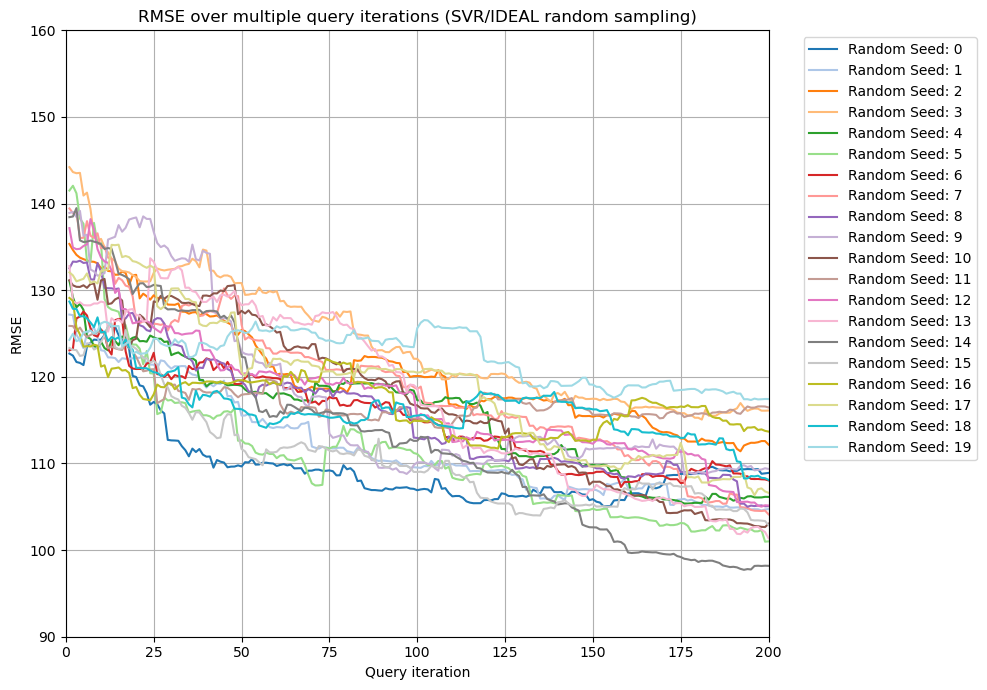

In [54]:
from ideal import ideal
from copy import deepcopy
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

# initial training data
X_pool_unscaled = deepcopy(X_TRAIN).to_numpy()
y_pool = deepcopy(y_TRAIN).to_numpy()

# test data
X_test_unscaled = deepcopy(X_TEST).to_numpy()
y_test = deepcopy(y_TEST).to_numpy()

# SCALING OF DATA!
# Instantiate StandardScaler
scaler = StandardScaler()

# Fit the scaler to your training data
scaler.fit(X_pool_unscaled)

# Transform the training data
X_pool = scaler.transform(X_pool_unscaled)

# Transform the test data
X_test = scaler.transform(X_test_unscaled)

# re-train predictor every T_train samples
T_train = 1
# weight on IDW function
delta = 0.3
# initializing of committee
n_init = 50
# store results in dictionary
results = {}
# hyperparameters
pred_type = "regression"
# maximum iterations
n_iter = 200
# total iterations
maxevals = n_init + n_iter
# number of iterations (random seeds)
iterations = 20

for i in range(iterations):
    print(f"Current iteration: {i}")

    # set random seed
    np.random.seed(i)

    pred = SVR(kernel="rbf", gamma="scale", C=3500.0, epsilon=0.01)

    data = {"X": X_pool, "Y": y_pool, "X_test": X_test, "Y_test": y_test}

    trained_pred, samples, scores = ideal.ideal_training(
        data,
        pred,
        pred_type,
        delta=delta,
        n_init=n_init,
        maxevals=maxevals,
        method="random",
        init_method="random",
        verbose=1,
    )
    results[i] = scores["test"]

# save the results as a csv file
rsme_df = pd.DataFrame(results)
rsme_df.to_csv("SVR_RSME_results_IDEAL_randomsampling.csv")


# Plot section
plt.figure(figsize=(10, 7))
cmap = plt.get_cmap("tab20")

for i, scores["test"] in results.items():
    color = cmap(i / iterations)  # color map
    plt.plot(
        np.arange(1, 201),
        scores["test"][n_init:maxevals],
        label=f"Random Seed: {i}",
        color=color,
    )

plt.title("RMSE over multiple query iterations (SVR/IDEAL random sampling)")
plt.xlabel("Query iteration")
plt.ylabel("RMSE")
plt.ylim(90, 160)
plt.xlim(0, 200)
plt.legend(loc="upper left", bbox_to_anchor=(1.04, 1))
plt.tight_layout()
plt.grid(True)
plt.savefig("SVR_multiple_iterations_IDEAL_randomsampling.png")
plt.show()

### Comparison of IDEAL and Random Sampling (IDEAL)

In [ ]:
# remove empty rows (pre-processing)
import pandas as pd

def preprocess_data(file):
    """
    Removes empty rows from a CSV file and saves the cleaned data with a new filename.
    
    Parameters:
    file (str): Path to the input CSV file.
    """
    # import data
    df = pd.read_csv(file, index_col=0)    
    # remove empty rows
    df = df.dropna()
    # save data with new extension
    file_df = file.replace(".csv", "_preprocessed.csv")
    df.to_csv(file_df)
    print(f"Saved results to {file_df}")

In [9]:
# save all files in a list of files
files = [
    "RF_RSME_results_IDEAL.csv",
    "RF_RSME_results_IDEAL_randomsampling.csv",
    "SVR_RSME_results_IDEAL.csv",
    "SVR_RSME_results_IDEAL_randomsampling.csv",
]

# process all files
for file in files:
    preprocess_data(file)

Saved results to RF_RSME_results_IDEAL_preprocessed.csv
Saved results to RF_RSME_results_IDEAL_randomsampling_preprocessed.csv
Saved results to SVR_RSME_results_IDEAL_preprocessed.csv
Saved results to SVR_RSME_results_IDEAL_randomsampling_preprocessed.csv


In [11]:
files = [
    "RF_RSME_results_IDEAL_preprocessed.csv",
    "RF_RSME_results_IDEAL_randomsampling_preprocessed.csv",
    "SVR_RSME_results_IDEAL_preprocessed.csv",
    "SVR_RSME_results_IDEAL_randomsampling_preprocessed.csv",
]

# process all files
for file in files:
    process_data_csv(file)

Saved results to RF_RSME_results_IDEAL_preprocessed_processed.csv
Saved results to RF_RSME_results_IDEAL_randomsampling_preprocessed_processed.csv
Saved results to SVR_RSME_results_IDEAL_preprocessed_processed.csv
Saved results to SVR_RSME_results_IDEAL_randomsampling_preprocessed_processed.csv


#### Comparison IDW vs. random sampling (RF/IDEAL)

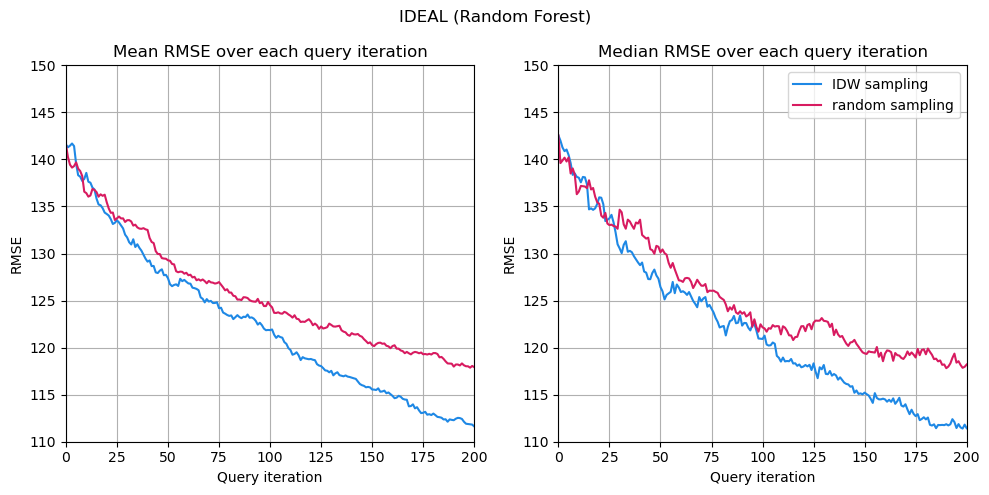

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# import the data
RF_sampling_IDEAL = pd.read_csv("RF_RSME_results_IDEAL_preprocessed_processed.csv")
RF_random_sampling_IDEAL = pd.read_csv("RF_RSME_results_IDEAL_randomsampling_preprocessed_processed.csv")

# extract mean and std dev values
RF_sampling_IDEAL_median = RF_sampling_IDEAL["Median"]
RF_sampling_IDEAL_mean = RF_sampling_IDEAL["Mean"]

RF_random_sampling_IDEAL_median = RF_random_sampling_IDEAL["Median"]
RF_random_sampling_IDEAL_mean = RF_random_sampling_IDEAL["Mean"]

# PLOT SECTION
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# mean
# Plot IDW
ax[0].plot(
    range(len(RF_sampling_IDEAL_mean)),
    RF_sampling_IDEAL_mean,
    linestyle="-",
    color="#1E88E5",
    label="IDW sampling",
)

# Plot random
ax[0].plot(
    range(len(RF_random_sampling_IDEAL_mean)),
    RF_random_sampling_IDEAL_mean,
    linestyle="-",
    color="#D81B60",
    label="random sampling",
)

ax[0].set_title("Mean RMSE over each query iteration")
ax[0].set_xlabel("Query iteration")
ax[0].set_ylabel("RMSE")
ax[0].set_xlim(0, 200)
ax[0].set_ylim(110, 150)
ax[0].grid(True)

# median
# Plot IDW
ax[1].plot(
    range(len(RF_sampling_IDEAL_median)),
    RF_sampling_IDEAL_median,
    linestyle="-",
    color="#1E88E5",
    label="IDW sampling",
)

# Plot random
ax[1].plot(
    range(len(RF_random_sampling_IDEAL_median)),
    RF_random_sampling_IDEAL_median,
    linestyle="-",
    color="#D81B60",
    label="random sampling",
)

ax[1].set_title("Median RMSE over each query iteration")
ax[1].set_xlabel("Query iteration")
ax[1].set_ylabel("RMSE")
ax[1].set_xlim(0, 200)
ax[1].set_ylim(110, 150)
ax[1].grid(True)


plt.suptitle("IDEAL (Random Forest)")
plt.legend()
plt.tight_layout()
plt.savefig("RF_IDEAL_IDW_vs_random_sampling_median_mean.png")
plt.show()

#### Comparison IDW vs. random sampling (SVR/IDEAL)

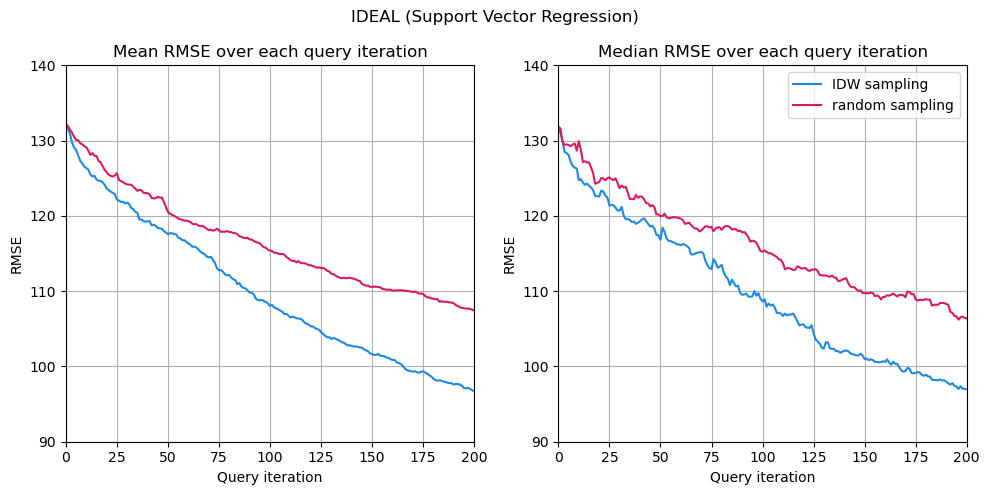

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# import the data
SVR_sampling_IDEAL = pd.read_csv("SVR_RSME_results_IDEAL_preprocessed_processed.csv")
SVR_random_sampling_IDEAL = pd.read_csv("SVR_RSME_results_IDEAL_randomsampling_preprocessed_processed.csv")

# extract mean and std dev values
SVR_sampling_IDEAL_median = SVR_sampling_IDEAL["Median"]
SVR_sampling_IDEAL_mean = SVR_sampling_IDEAL["Mean"]

SVR_random_sampling_IDEAL_median = SVR_random_sampling_IDEAL["Median"]
SVR_random_sampling_IDEAL_mean = SVR_random_sampling_IDEAL["Mean"]

# PLOT SECTION
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# mean
# Plot IDW
ax[0].plot(
    range(len(SVR_sampling_IDEAL_mean)),
   SVR_sampling_IDEAL_mean,
    linestyle="-",
    color="#1E88E5",
    label="IDW sampling",
)

# Plot random
ax[0].plot(
    range(len(SVR_random_sampling_IDEAL_mean)),
    SVR_random_sampling_IDEAL_mean,
    linestyle="-",
    color="#D81B60",
    label="random sampling",
)

ax[0].set_title("Mean RMSE over each query iteration")
ax[0].set_xlabel("Query iteration")
ax[0].set_ylabel("RMSE")
ax[0].set_xlim(0, 200)
ax[0].set_ylim(90, 140)
ax[0].grid(True)

# median
# Plot IDW
ax[1].plot(
    range(len(SVR_sampling_IDEAL_median)),
    SVR_sampling_IDEAL_median,
    linestyle="-",
    color="#1E88E5",
    label="IDW sampling",
)

# Plot random
ax[1].plot(
    range(len(SVR_random_sampling_IDEAL_median)),
    SVR_random_sampling_IDEAL_median,
    linestyle="-",
    color="#D81B60",
    label="random sampling",
)

ax[1].set_title("Median RMSE over each query iteration")
ax[1].set_xlabel("Query iteration")
ax[1].set_ylabel("RMSE")
ax[1].set_xlim(0, 200)
ax[1].set_ylim(90, 140)
ax[1].grid(True)


plt.suptitle("IDEAL (Support Vector Regression)")
plt.legend()
plt.tight_layout()
plt.savefig("SVR_IDEAL_IDW_vs_random_sampling_median_mean.png")
plt.show()


### Comparison of IDEAL and QBC

#### Random Forest

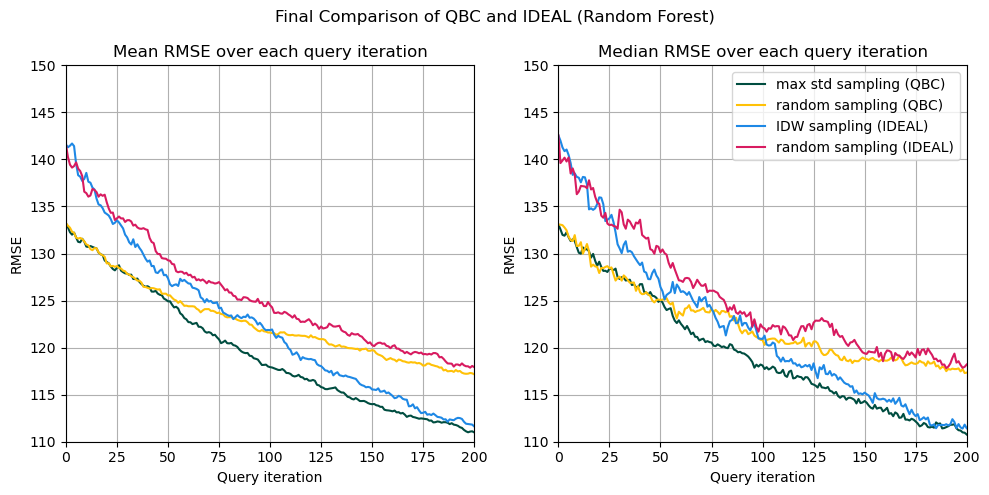

In [14]:
# PLOT SECTION
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

### MEAN
## QBC
# Plot max_std
ax[0].plot(
    range(len(RF_max_std_mean)),
    RF_max_std_mean,
    linestyle="-",
    color="#004D40",
    label="max std sampling (QBC)",
)

# Plot random
ax[0].plot(
    range(len(RF_random_mean)),
    RF_random_mean,
    linestyle="-",
    color="#FFC107",
    label="random sampling (QBC)",
)

## IDEAL
# Plot IDW
ax[0].plot(
    range(len(RF_sampling_IDEAL_mean)),
    RF_sampling_IDEAL_mean,
    linestyle="-",
    color="#1E88E5",
    label="IDW sampling (IDEAL)",
)

# Plot random
ax[0].plot(
    range(len(RF_random_sampling_IDEAL_mean)),
    RF_random_sampling_IDEAL_mean,
    linestyle="-",
    color="#D81B60",
    label="random sampling (IDEAL)",
)

ax[0].set_title("Mean RMSE over each query iteration")
ax[0].set_xlabel("Query iteration")
ax[0].set_ylabel("RMSE")
ax[0].set_xlim(0, 200)
ax[0].set_ylim(110, 150)
ax[0].grid(True)

### MEDIAN
## QBC
# Plot max_std
ax[1].plot(
    range(len(RF_max_std_median)),
    RF_max_std_median,
    linestyle="-",
    color="#004D40",
    label="max std sampling (QBC)",
)

# Plot random
ax[1].plot(
    range(len(RF_random_median)),
    RF_random_median,
    linestyle="-",
    color="#FFC107",
    label="random sampling (QBC)",
)

## IDEAL
# Plot IDW
ax[1].plot(
    range(len(RF_sampling_IDEAL_median)),
    RF_sampling_IDEAL_median,
    linestyle="-",
    color="#1E88E5",
    label="IDW sampling (IDEAL)",
)

# Plot random
ax[1].plot(
    range(len(RF_random_sampling_IDEAL_median)),
    RF_random_sampling_IDEAL_median,
    linestyle="-",
    color="#D81B60",
    label="random sampling (IDEAL)",
)

ax[1].set_title("Median RMSE over each query iteration")
ax[1].set_xlabel("Query iteration")
ax[1].set_ylabel("RMSE")
ax[1].set_xlim(0, 200)
ax[1].set_ylim(110, 150)
ax[1].grid(True)

plt.suptitle("Final Comparison of QBC and IDEAL (Random Forest)")
plt.legend()
plt.tight_layout()
plt.savefig("RF_QBC_IDEAL_comparison.png")
plt.show()

#### Support Vector Regression

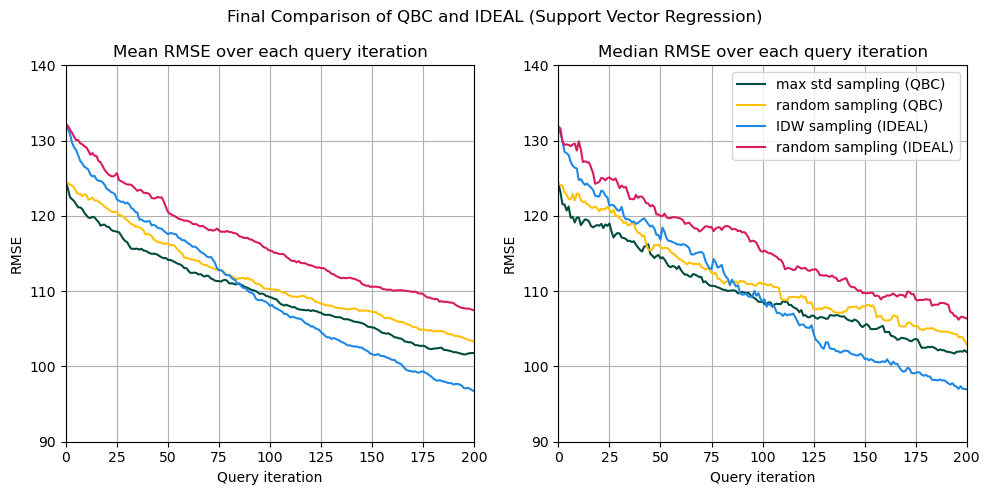

In [15]:
# PLOT SECTION
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

### MEAN
## QBC
# Plot max_std
ax[0].plot(
    range(len(SVR_max_std_mean)),
    SVR_max_std_mean,
    linestyle="-",
    color="#004D40",
    label="max std sampling (QBC)",
)

# Plot random
ax[0].plot(
    range(len(SVR_random_mean)),
    SVR_random_mean,
    linestyle="-",
    color="#FFC107",
    label="random sampling (QBC)",
)

## IDEAL
# Plot IDW
ax[0].plot(
    range(len(SVR_sampling_IDEAL_mean)),
    SVR_sampling_IDEAL_mean,
    linestyle="-",
    color="#1E88E5",
    label="IDW sampling (IDEAL)",
)

# Plot random
ax[0].plot(
    range(len(SVR_random_sampling_IDEAL_mean)),
    SVR_random_sampling_IDEAL_mean,
    linestyle="-",
    color="#D81B60",
    label="random sampling (IDEAL)",
)

ax[0].set_title("Mean RMSE over each query iteration")
ax[0].set_xlabel("Query iteration")
ax[0].set_ylabel("RMSE")
ax[0].set_xlim(0, 200)
ax[0].set_ylim(90, 140)
ax[0].grid(True)

### MEDIAN
## QBC
# Plot max_std
ax[1].plot(
    range(len(SVR_max_std_median)),
    SVR_max_std_median,
    linestyle="-",
    color="#004D40",
    label="max std sampling (QBC)",
)

# Plot random
ax[1].plot(
    range(len(SVR_random_median)),
    SVR_random_median,
    linestyle="-",
    color="#FFC107",
    label="random sampling (QBC)",
)

## IDEAL
# Plot IDW
ax[1].plot(
    range(len(SVR_sampling_IDEAL_median)),
    SVR_sampling_IDEAL_median,
    linestyle="-",
    color="#1E88E5",
    label="IDW sampling (IDEAL)",
)

# Plot random
ax[1].plot(
    range(len(SVR_random_sampling_IDEAL_median)),
    SVR_random_sampling_IDEAL_median,
    linestyle="-",
    color="#D81B60",
    label="random sampling (IDEAL)",
)

ax[1].set_title("Median RMSE over each query iteration")
ax[1].set_xlabel("Query iteration")
ax[1].set_ylabel("RMSE")
ax[1].set_xlim(0, 200)
ax[1].set_ylim(90, 140)
ax[1].grid(True)

plt.suptitle("Final Comparison of QBC and IDEAL (Support Vector Regression)")
plt.legend()
plt.tight_layout()
plt.savefig("SVR_QBC_IDEAL_comparison.png")
plt.show()